In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from itertools import combinations 
import seaborn as sns
from cartopy import crs as ccrs, feature as cfeature

plt.rcParams['figure.dpi'] = 400

In [2]:
!module load miniconda
!conda create -n mosquito jupyter jupyterlab seaborn matplotlib cartopy pandas numpy --yes


CommandNotFoundError: Your shell has not been properly configured to use 'conda deactivate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.


Channels:
 - conda-forge
 - bioconda
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 23.3.1
    latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /gpfs/gibbs/project/isaacs/ewa2/conda_envs/mosquito

  added / updated specs:
    - cartopy
    - jupyter
    - jupyterlab
    - matplotlib
    - numpy
    - pandas
    - seaborn


The following packages will be downloaded:

    package                    |            build
  

 ... (more hidden) ...

nbconvert-7.6.0      | 8 KB      | ##################################### | 100% 
pip-23.1.2           | 1.3 MB    | 4                                     |   1% 



jupyterlab_server-2. | 59 KB     | ##########                            |  27% 


python-fastjsonschem | 220 KB    | ##6                                   |   7% 




qtpy-2.3.1           | 55 KB     | ##########8                           |  29% 






contourpy-1.1.0      | 225 KB    | ##6                                   |   7% 





shapely-2.0.1        | 483 KB    | #2                                    |   3% 







pyproj-3.6.0         | 484 KB    | #2                                    |   3% 









libopenblas-0.3.23   | 5.2 MB    | 1                                     |   0% 








pixman-0.40.0        | 627 KB    | 9                                     |   3% 

nbconvert-7.6.0      | 8 KB      | ##################################### | 100% 










sqlite-3.42.0        | 799 KB 
















































































































































































































































































































Preparing transaction: done
Verifying transaction: done
Executing transaction: done
#
# To activate this environment, use
#
#     $ conda activate mosquito
#
# To deactivate an active environment, use
#
#     $ conda deactivate



# Dataset

In [2]:
# read in all Sri Lanka metadata
metadata = pd.read_csv("../data/sri_lanka_metadata.txt", sep="\t")
metadata = metadata.rename(columns={"Sample": "IID"})
metadata["salinity (ppm)"] = metadata["Phenotype"].str.extract("(\d*)").astype(int)
print(f"Before filtering, there are {len(metadata)} individuals Sri Lanka mosquito samples.")

Before filtering, there are 121 individuals Sri Lanka mosquito samples.


# Quality control
## Plink quality control  

1. Eliminate SNPs that did not genotype well, that is, SNPs that do not exist in >80% of individuals. `./plink --geno 0.2`
2. Only allow individuals with less than 5% missing data. `./plink --mind 0.05`
3. Filter out all variants with minor allele frequency below 0.01. These are likely to be sequencing errors. Also remove the variants that are in linkage disequilibrium with each other `./plink --maf 0.01 --indep 75k 1 2`
4. Keep only individuals which cluster in Asia. 

In [3]:
filtered = pd.read_csv("../data/sri-lanka-all-plink/SriLanka_only.fam", sep="\s+", names=["FID", "IID", "Within-family ID of father", "Within-family ID of mother", "Sex code", "Phenotype value"])
print(f"After filtering, there are {len(filtered)} individuals Sri Lanka mosquito samples.")
metadata_filtered = metadata[metadata["IID"].isin(filtered["IID"])]
metadata_filtered.head()

After filtering, there are 73 individuals Sri Lanka mosquito samples.


Chip Plate_Location Population_Name no_accent_pop_name       IID  \
0    55            A07          Jaffna             Jaffna   FW01_01   
1    55            A08          Jaffna             Jaffna   FW02_04   
2    55            A09          Nallur             Nallur   FW04_02   
5    55            A12           Kopay              Kopay   FW09_01   
6    55            B07          Jaffna             Jaffna  FW01_02A   

  CEL_file_name  Sex  Paternal_ID  Maternal_ID Phenotype  ... Private/Public  \
0       FW01_01  NaN          NaN          NaN      0ppt  ...        Private   
1       FW02_04  NaN          NaN          NaN      0ppt  ...        Private   
2       FW04_02  NaN          NaN          NaN      0ppt  ...        Private   
5       FW09_01  NaN          NaN          NaN      0ppt  ...        Private   
6      FW01_02A  NaN          NaN          NaN      0ppt  ...        Private   

     City State/Province    Country  Region   Latitude  Longitude Year  \
0  Jaffna            NaN  Sri Lanka     NaN  9.6650403  80.020598  NaN   
1  Jaffna            NaN  Sri Lanka     NaN  9.6650403  80.020598  NaN   
2  Nallur            NaN  Sri Lanka     NaN  9.6707887  80.030162  NaN   
5   Kopay            NaN  Sri Lanka     NaN   9.705016  80.057540  NaN   
6  Jaffna            NaN  Sri Lanka     NaN  9.6650403  80.020598  NaN   

   Include_in_chip_manuscript  salinity (ppm)  
0                         NaN               0  
1                         NaN               0  
2                         NaN               0  
5                         NaN               0  
6                         NaN               0  

[5 rows x 22 columns]

## Remove siblings
From Andrea: An estimated kinship coefficient range >0.354, [0.177, 0.354], [0.0884, 0.177] and [0.0442, 0.0884] corresponds to duplicate/MZ twin, 1st-degree, 2nd-degree, and 3rd-degree relationships respectively.

`vcftools --vcf SriLanka_only_relate.vcf --relatedness2 --out SriLanka_only_relate_Res` 

In [4]:
related = pd.read_csv("../data/SriLanka_only_relate_Res.relatedness2", sep="\t")

# Get all the individuals that are related by 1st degree or higher relationships 
related = related[related["RELATEDNESS_PHI"] > 0.117]

seen = {}
unique = []
for i, row in related.iterrows():
    if row["INDV1"] not in seen:
        seen[row["INDV1"]] = 1
        unique.append(True)
    else:
        unique.append(False)
    seen[row["INDV2"]] = 1

unrelated = related[unique]
metadata_unrelated = metadata_filtered[metadata_filtered["IID"].isin(list(unrelated["INDV1"]))]
print("Sequences after removing siblings", len(metadata_unrelated))

Sequences after removing siblings 30


In [39]:
metadata_unrelated[["Population_Name", "IID"]].to_csv('../data/no_siblings.txt', sep='\t', header=False, index=False)

In [47]:
!../../plink/plink --file SriLanka_only --keep no_siblings.txt --allow-extra-chr --make-bed --recode --out SriLanka_no_sib

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SriLanka_no_sib.log.
Options in effect:
  --allow-extra-chr
  --file SriLanka_only
  --keep no_siblings.txt
  --make-bed
  --out SriLanka_no_sib
  --recode

128238 MB RAM detected; reserving 64119 MB for main workspace.
.ped scan complete (for binary autoconversion).728303132343536383941424345464749505253545657586061636465676869717273757678798082838486878990919394959798100%
Performing single-pass .bed write (11007 variants, 73 people).
--file: SriLanka_no_sib-temporary.bed + SriLanka_no_sib-temporary.bim +546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394%
SriLanka_no_sib-temporary.fam written.
11007 variants loaded from .bim file.
73 people (0 males, 0 females, 73 ambiguous) loaded from .fam.
Ambiguous sex IDs written to SriLanka_no_sib.nosex .
--keep: 30 people remainin

# PCA

In [58]:
!../../plink/plink --bfile SriLanka_no_sib  --pca 'header' 'tabs' 'var-wts' --allow-extra-chr --chr 3001 3002 3003

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --allow-extra-chr
  --bfile SriLanka_no_sib
  --chr 3001 3002 3003
  --pca header tabs var-wts

128238 MB RAM detected; reserving 64119 MB for main workspace.
10545 out of 11007 variants loaded from .bim file.
30 people (0 males, 0 females, 30 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink.nosex .
Using up to 19 threads (change this with --threads).
Before main variant filters, 30 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.984407.
10545 variants and 30 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculat

View the eigenvalues  

<Axes: xlabel='Principal component', ylabel='Variance explained (%)'>

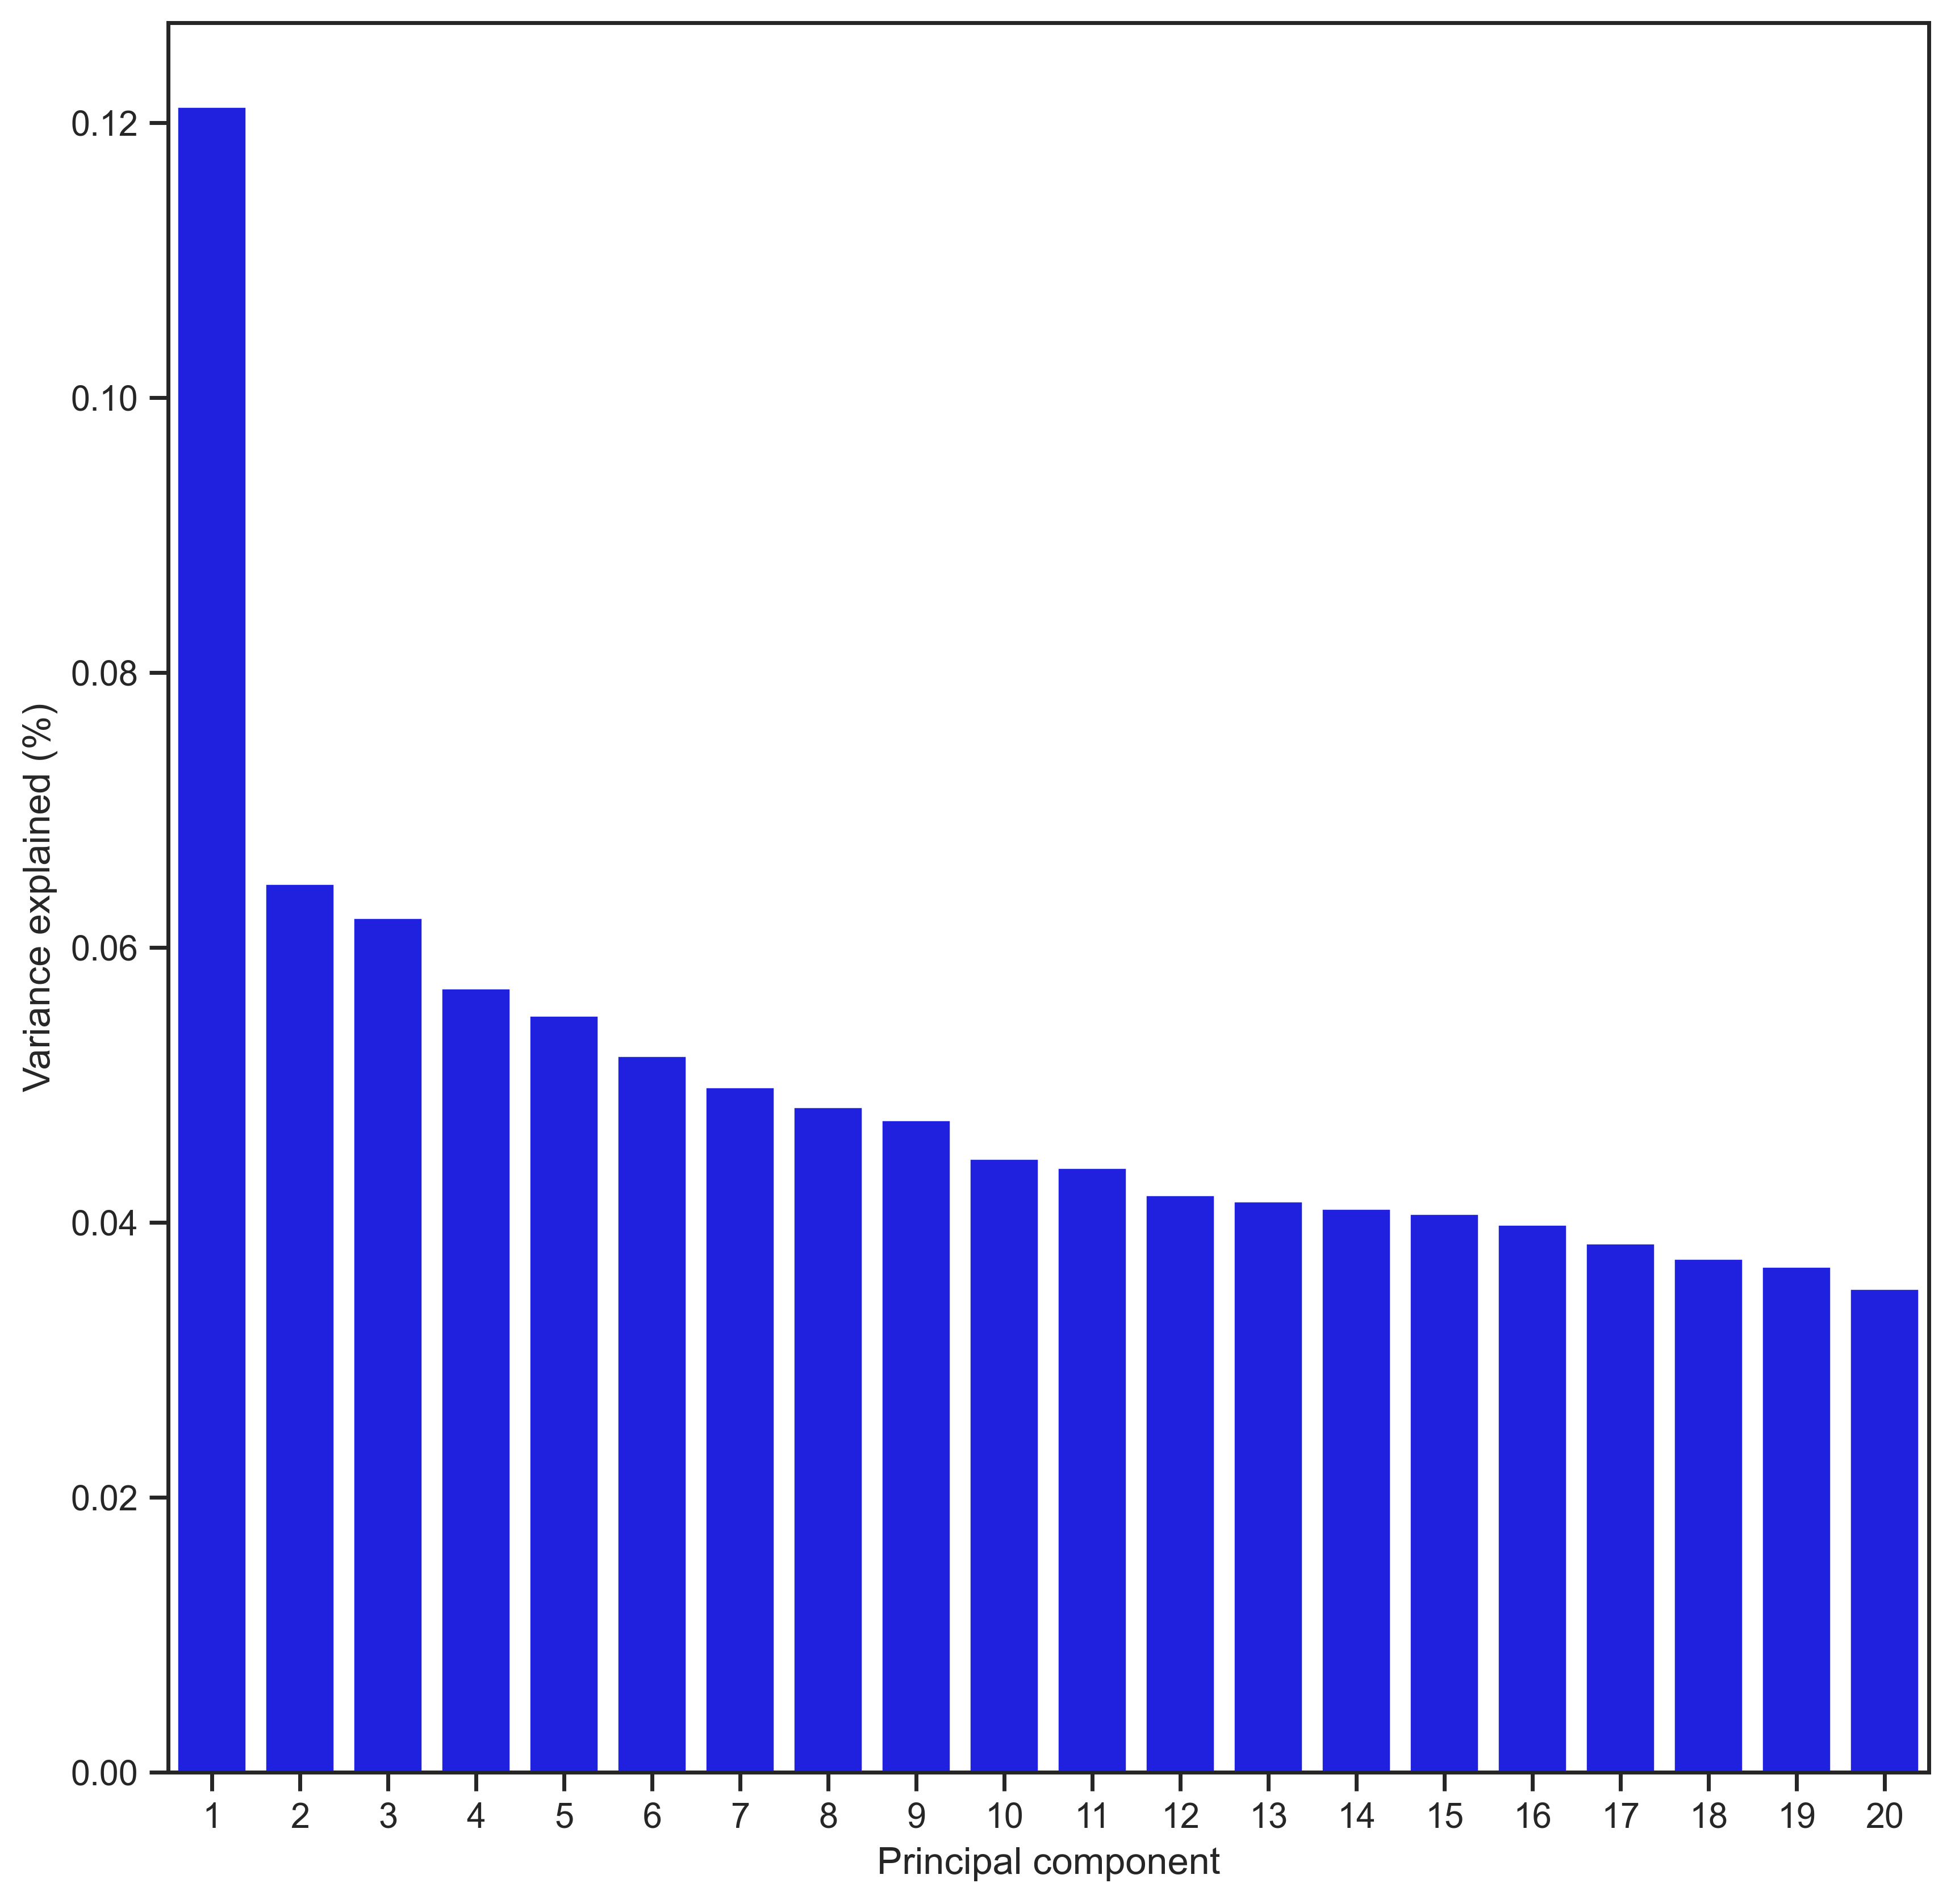

In [6]:
eigenval = pd.read_csv("../data/pca/plink.eigenval", sep="\t", header=None)
eigenval = eigenval.rename(columns={0: "eigenval"})
eigenval["Variance explained (%)"] = eigenval["eigenval"] / np.sum(eigenval["eigenval"])
eigenval["Principal component"] = np.arange(len(eigenval)) + 1

sns.set(rc = {'figure.figsize':(10,10)})
sns.set_style("ticks")
sns.barplot(data=eigenval, x="Principal component", y="Variance explained (%)", color="blue")


In [65]:
eigenval["Variance explained (%)"]

0     0.121215
1     0.064659
2     0.062206
3     0.057076
4     0.055075
5     0.052163
6     0.049866
7     0.048443
8     0.047497
9     0.044676
10    0.043997
11    0.042045
12    0.041570
13    0.041031
14    0.040642
15    0.039891
16    0.038515
17    0.037412
18    0.036811
19    0.035209
Name: Variance explained (%), dtype: float64

In [7]:
metadata = pd.read_csv("../data/sri_lanka_metadata.txt", sep="\t")
metadata = metadata.rename(columns={"Sample": "IID", "City": "City"})
metadata["salinity (ppm)"] = metadata["Phenotype"].str.extract("(\d*)").astype(int)

PC = pd.read_csv("../data/pca/plink.eigenvec", sep="\t")
PC_data = pd.merge(PC, metadata, on="IID", how="left")
PC_data = PC_data.rename(columns={"PC1": "PC1 (12.12%)", "PC2": "PC2 (6.4%)"})
PC_data["salinity (ppm)"] = pd.to_numeric(PC_data["salinity (ppm)"])
PC_data["Water Type"] = (PC_data["salinity (ppm)"] > 0).replace({True: "Brackish", False: "Fresh"})
PC_data = PC_data.sort_values(by="City")

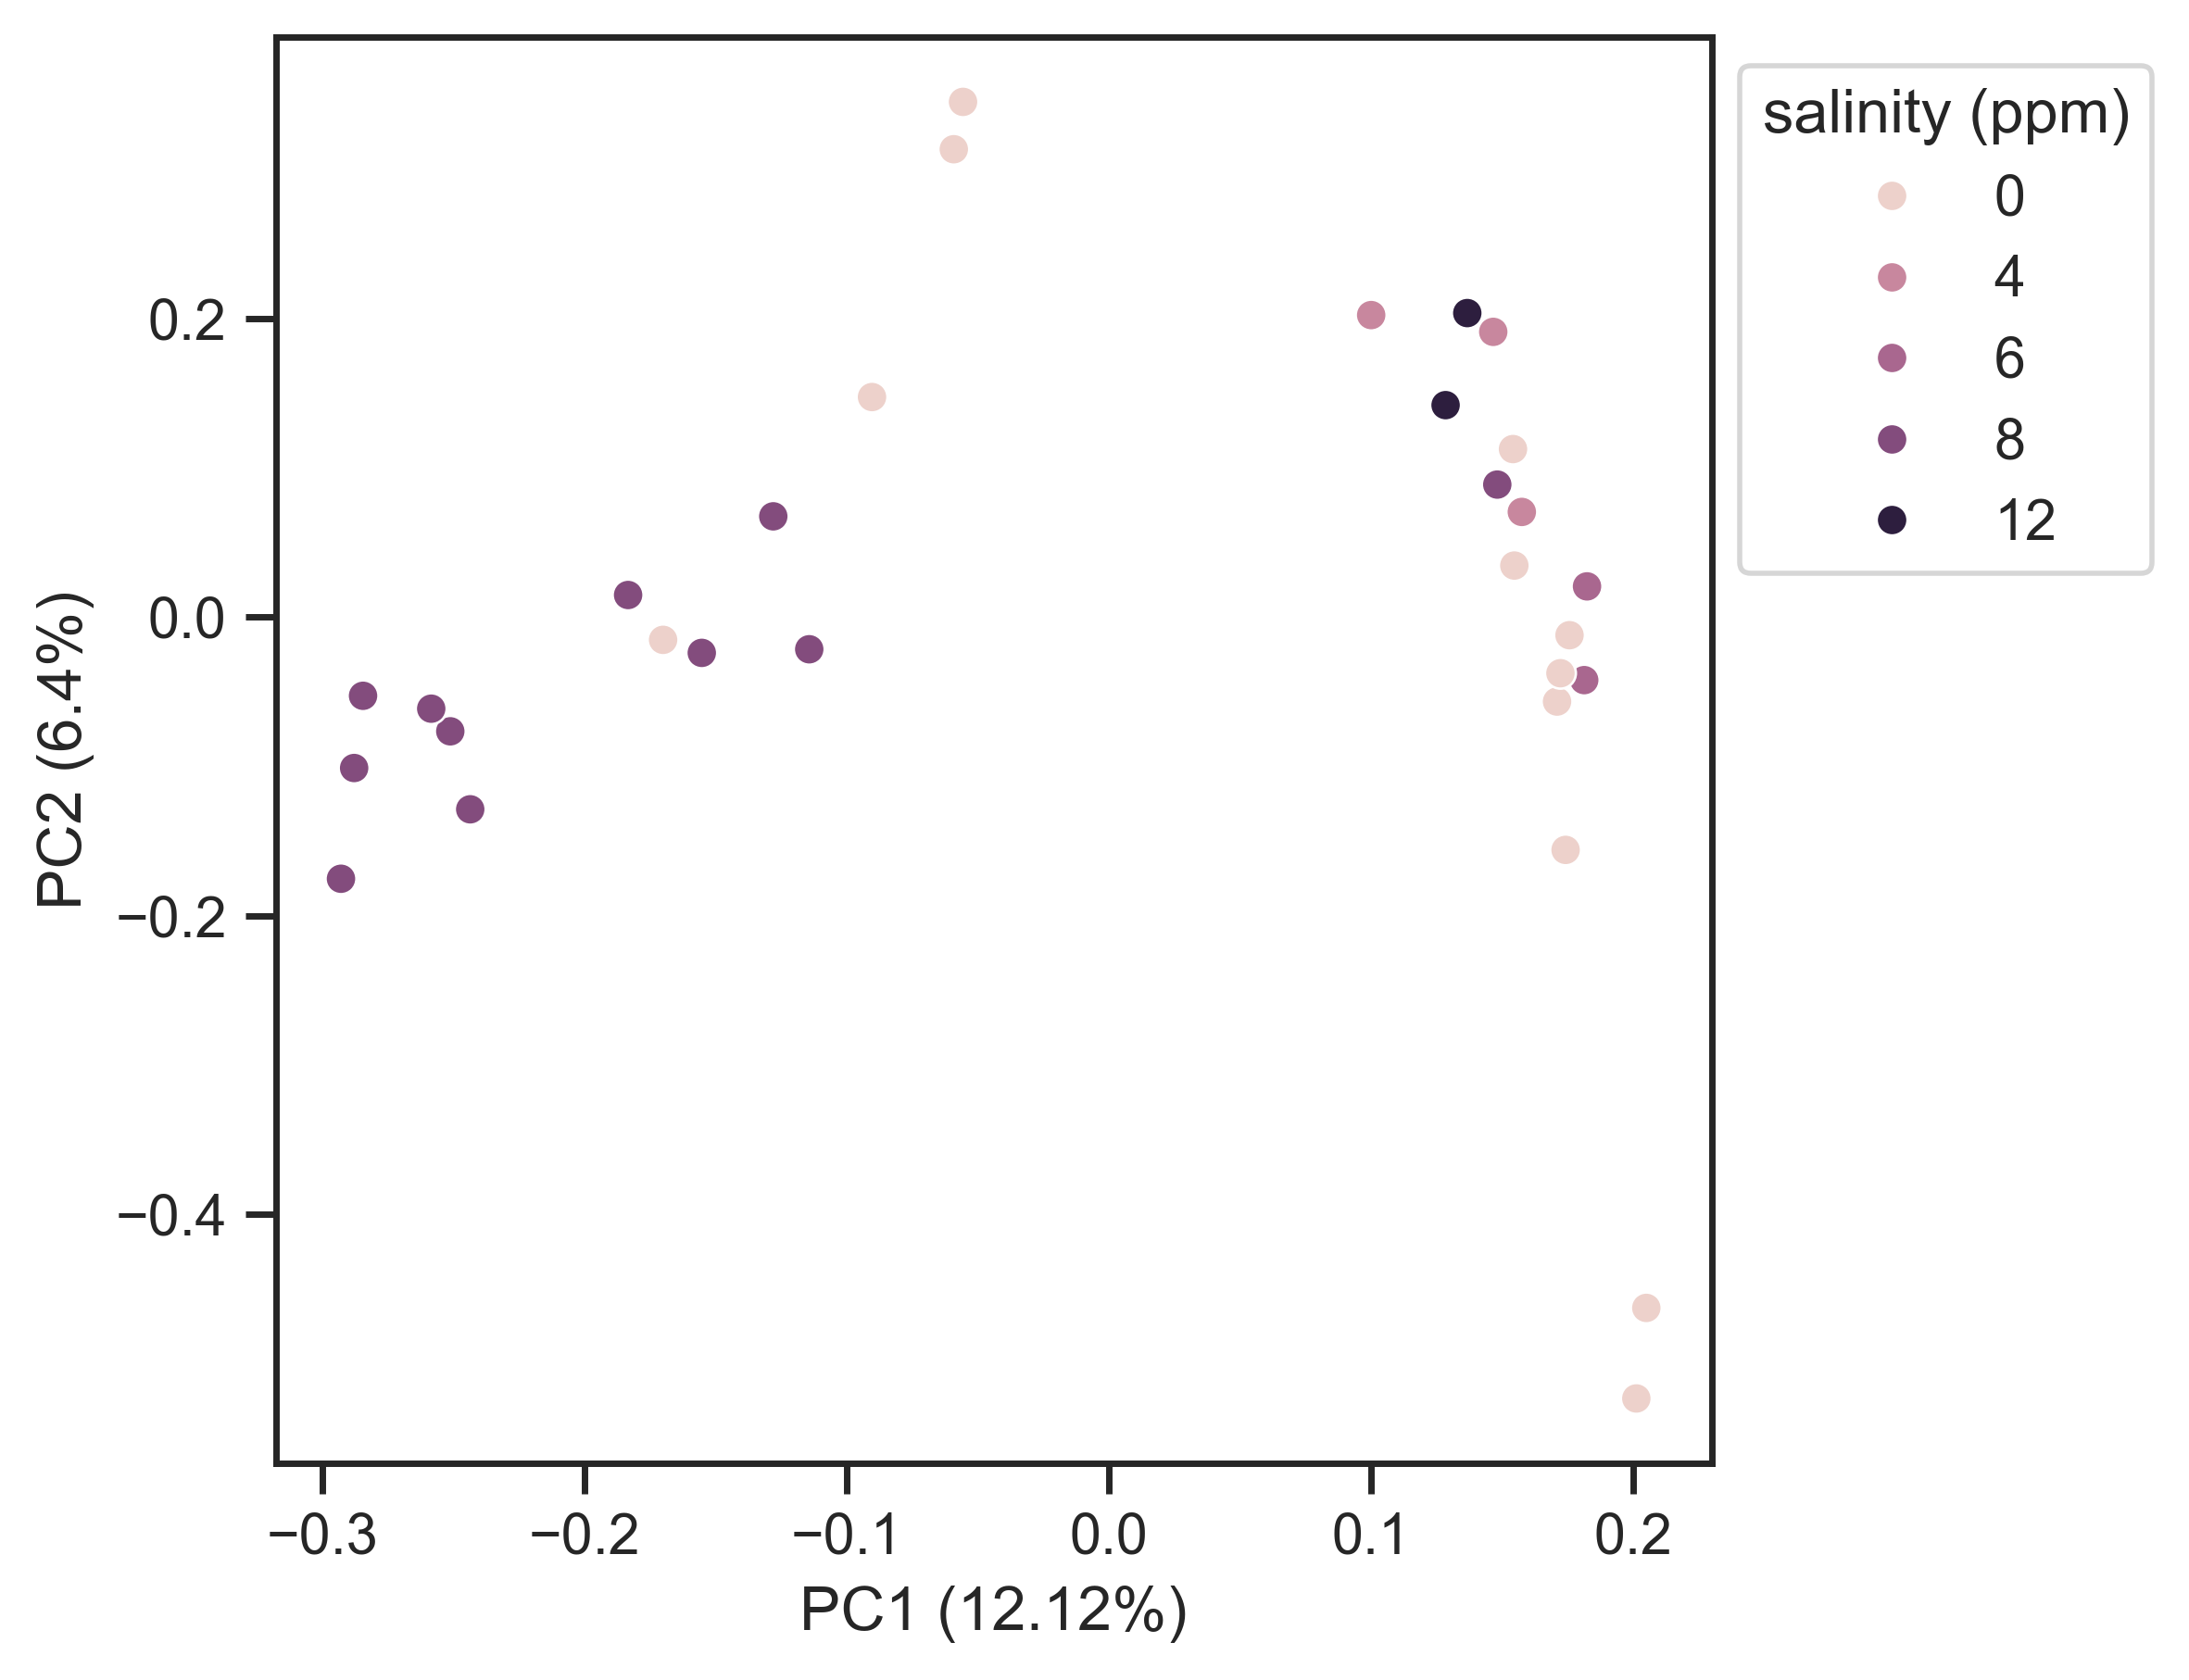

In [8]:
sns.set(rc = {'figure.figsize':(5,5)})
sns.set_style("ticks")
ax = sns.scatterplot(data=PC_data, x="PC1 (12.12%)", y="PC2 (6.4%)", hue="salinity (ppm)")
plt.legend(title="salinity (ppm)")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

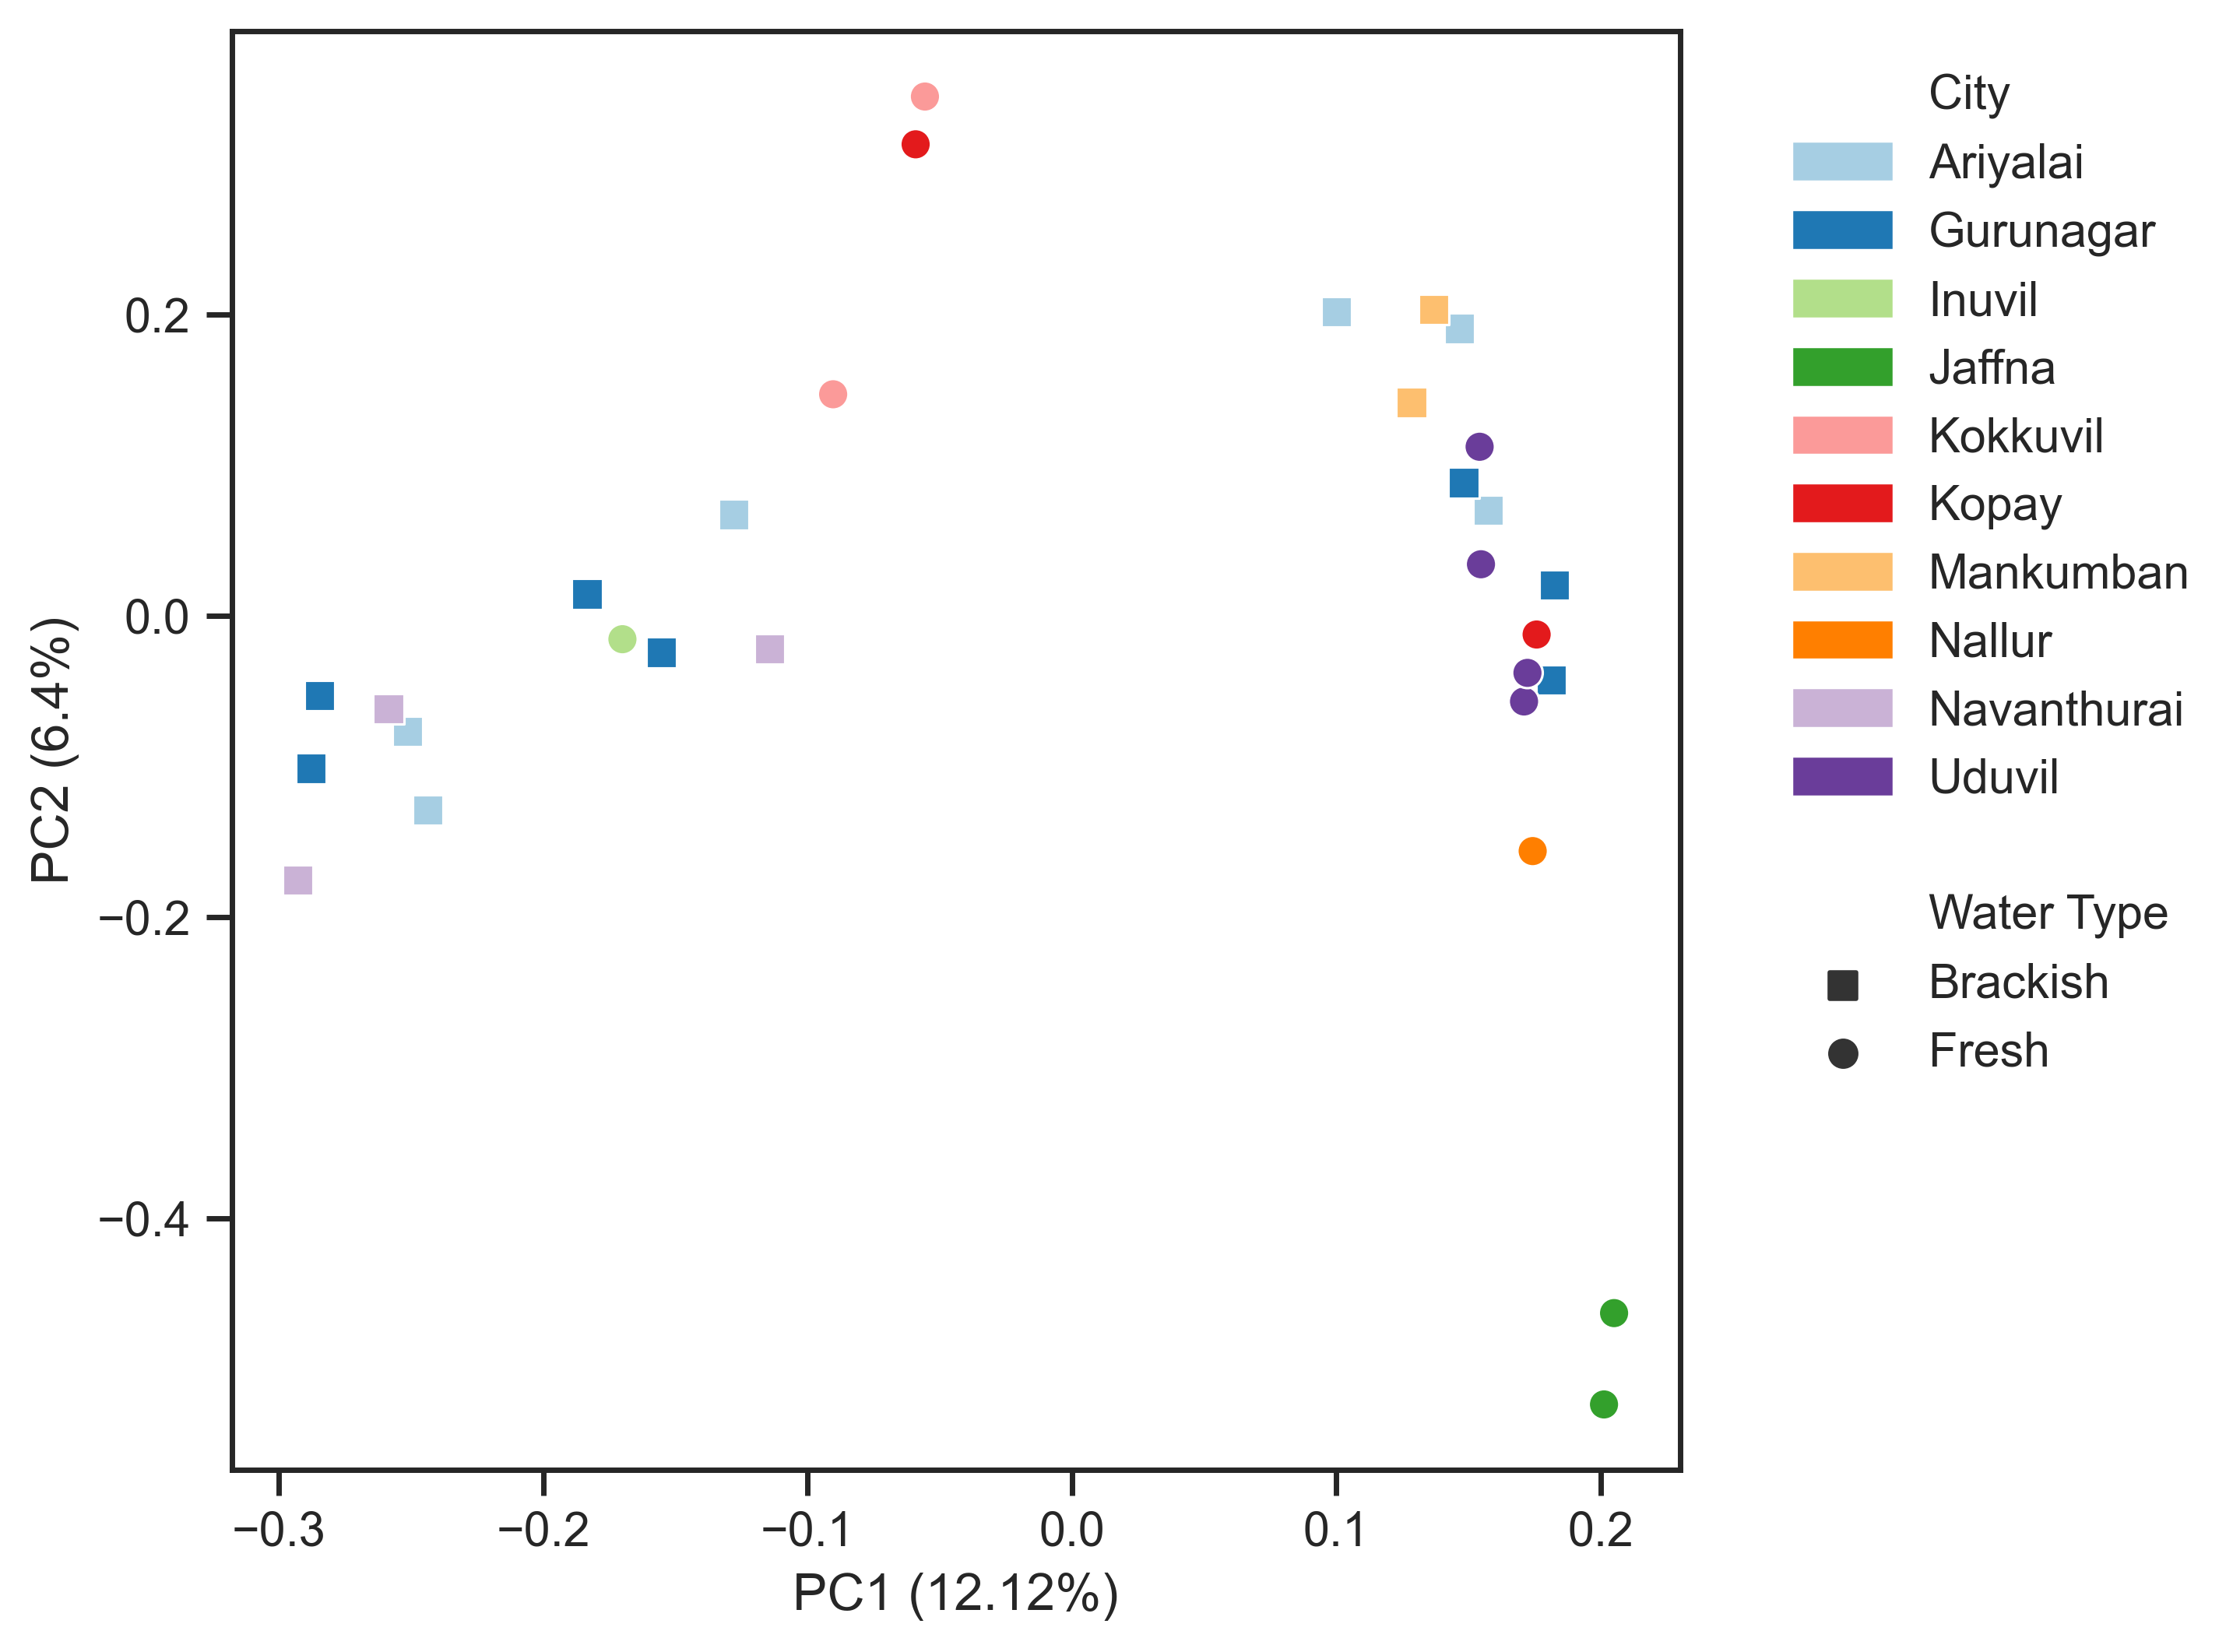

In [68]:
import matplotlib.patches as mpatches

sns.set(rc = {'figure.figsize':(6,6)})
sns.set_style("ticks")
sns.set_palette("Paired")
ax = sns.scatterplot(data=PC_data, x="PC1 (12.12%)", y="PC2 (6.4%)", hue="City", style="Water Type", s=50, markers=["s", "o"])

legends = ax.legend()
custom_legend = [mpatches.Patch(color="white", label="City")]
for j, obj in enumerate(legends.get_texts()[1:11]):
    custom_legend.append(mpatches.Patch(color=sns.color_palette("Paired")[j], label=obj.get_text()))
handles, labels = ax.get_legend_handles_labels()

custom_legend.append(mpatches.Patch(color="white", label=""))
custom_legend.append(mpatches.Patch(color="white", label="Water Type"))
custom_legend.append(handles[-2])
custom_legend.append(handles[-1])

ax.legend(handles=custom_legend, frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1))

plt.show()

# Fst Pairwise

module load VCFtools

vcftools --gzvcf SriLanka_only_relate.vcf --weir-fst-pop FW_samples_all.txt --weir-fst-pop BW_samples_all.txt --out ./FW_BW


In [69]:
# make files for each of the samples 
grp = PC_data.groupby("City")
for key, item in grp:
    samples = '\n'.join(grp.get_group(key)["IID"]) + '\n'
    with open(f"fst/{key}.txt", "w+") as f:
        f.write(samples)

In [70]:
# calculate fsts between all pairs  
from itertools import combinations

cities = list(PC_data["City"].unique())

for combination in combinations(cities, 2):
    command = f"module load VCFtools && vcftools --gzvcf SriLanka_only_relate.vcf --weir-fst-pop fst/{combination[0]}.txt --weir-fst-pop fst/{combination[1]}.txt --out ./fst/{combination[0]}{combination[1]}.txt"
    !{command}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf SriLanka_only_relate.vcf
	--weir-fst-pop fst/Ariyalai.txt
	--weir-fst-pop fst/Gurunagar.txt
	--keep fst/Ariyalai.txt
	--keep fst/Gurunagar.txt
	--out ./fst/AriyalaiGurunagar.txt

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 13 out of 73 Individuals
Outputting Weir and Cockerham Fst estimates.
Weir and Cockerham mean Fst estimate: -0.009272
Weir and Cockerham weighted Fst estimate: -0.0039443
After filtering, kept 10545 out of a possible 10545 Sites
Run Time = 0.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf SriLanka_only_relate.vcf
	--weir-fst-pop fst/Ariyalai.txt
	--weir-fst-pop fst/Inuvil.txt
	--keep fst/Ariyalai.txt
	--keep fst/Inuvil.txt
	--out ./fst/AriyalaiInuvil.txt

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 7 out of 73 Individuals
Outputting

Weir and Cockerham mean Fst estimate: 0.029282
Weir and Cockerham weighted Fst estimate: 0.09351
After filtering, kept 10545 out of a possible 10545 Sites
Run Time = 0.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf SriLanka_only_relate.vcf
	--weir-fst-pop fst/Gurunagar.txt
	--weir-fst-pop fst/Kokkuvil.txt
	--keep fst/Gurunagar.txt
	--keep fst/Kokkuvil.txt
	--out ./fst/GurunagarKokkuvil.txt

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 9 out of 73 Individuals
Outputting Weir and Cockerham Fst estimates.
Weir and Cockerham mean Fst estimate: -0.012298
Weir and Cockerham weighted Fst estimate: 0.026285
After filtering, kept 10545 out of a possible 10545 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf SriLanka_only_relate.vcf
	--weir-fst-pop fst/Gurunagar.txt
	--weir-fst-pop fst/Kopay.txt
	--keep fst/Gurunagar.t

Weir and Cockerham mean Fst estimate: -nan
Weir and Cockerham weighted Fst estimate: -nan
After filtering, kept 10545 out of a possible 10545 Sites
Run Time = 0.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf SriLanka_only_relate.vcf
	--weir-fst-pop fst/Inuvil.txt
	--weir-fst-pop fst/Navanthurai.txt
	--keep fst/Inuvil.txt
	--keep fst/Navanthurai.txt
	--out ./fst/InuvilNavanthurai.txt

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 4 out of 73 Individuals
Outputting Weir and Cockerham Fst estimates.
Weir and Cockerham mean Fst estimate: -0.11175
Weir and Cockerham weighted Fst estimate: -0.0061926
After filtering, kept 10545 out of a possible 10545 Sites
Run Time = 0.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf SriLanka_only_relate.vcf
	--weir-fst-pop fst/Inuvil.txt
	--weir-fst-pop fst/Uduvil.txt
	--keep fst/Inuvil.txt
	--keep 

Weir and Cockerham mean Fst estimate: -0.039352
Weir and Cockerham weighted Fst estimate: 0.091601
After filtering, kept 10545 out of a possible 10545 Sites
Run Time = 0.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf SriLanka_only_relate.vcf
	--weir-fst-pop fst/Kokkuvil.txt
	--weir-fst-pop fst/Navanthurai.txt
	--keep fst/Kokkuvil.txt
	--keep fst/Navanthurai.txt
	--out ./fst/KokkuvilNavanthurai.txt

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 5 out of 73 Individuals
Outputting Weir and Cockerham Fst estimates.
Weir and Cockerham mean Fst estimate: 0.020888
Weir and Cockerham weighted Fst estimate: 0.069558
After filtering, kept 10545 out of a possible 10545 Sites
Run Time = 1.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf SriLanka_only_relate.vcf
	--weir-fst-pop fst/Kokkuvil.txt
	--weir-fst-pop fst/Uduvil.txt
	--keep fst/Kokk

Weir and Cockerham mean Fst estimate: -0.091108
Weir and Cockerham weighted Fst estimate: 0.02918
After filtering, kept 10545 out of a possible 10545 Sites
Run Time = 0.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf SriLanka_only_relate.vcf
	--weir-fst-pop fst/Navanthurai.txt
	--weir-fst-pop fst/Uduvil.txt
	--keep fst/Navanthurai.txt
	--keep fst/Uduvil.txt
	--out ./fst/NavanthuraiUduvil.txt

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 7 out of 73 Individuals
Outputting Weir and Cockerham Fst estimates.
Weir and Cockerham mean Fst estimate: 0.049688
Weir and Cockerham weighted Fst estimate: 0.093169
After filtering, kept 10545 out of a possible 10545 Sites
Run Time = 0.00 seconds


In [14]:
means = []
combo1 = []
combo2 = []
cities = ["Jaffna", "Nallur", "Navanthurai","Kokkuvil", "Uduvil", "Mankumban", "Kopay",  "Inuvil", "Gurunagar", "Ariyalai"][::-1]
for combo in combinations(cities, 2): 
    try:
        fst = pd.read_csv(f"fst/{combo[0]}{combo[1]}.txt.weir.fst", sep="\t")
    except FileNotFoundError as not_found: 
        fst = pd.read_csv(f"fst/{combo[1]}{combo[0]}.txt.weir.fst", sep="\t")
    mean = fst["WEIR_AND_COCKERHAM_FST"].mean() if fst["WEIR_AND_COCKERHAM_FST"].mean() > 0 else 0
    means.append(mean)
    combo1.append(combo[0])
    combo2.append(combo[1])

# for city in cities:
#     means.append(0)
#     combo1.append(city)
#     combo2.append(city)

pairfst = pd.DataFrame({"Population 1":combo1, "Population 2":combo2, "fst mean":means})
pairfst["fst mean"] = pairfst["fst mean"].round(2)
pairfst["Population 2"] = pd.Categorical(pairfst["Population 2"], cities)
pairfst["Population 1"] = pd.Categorical(pairfst["Population 1"], cities)

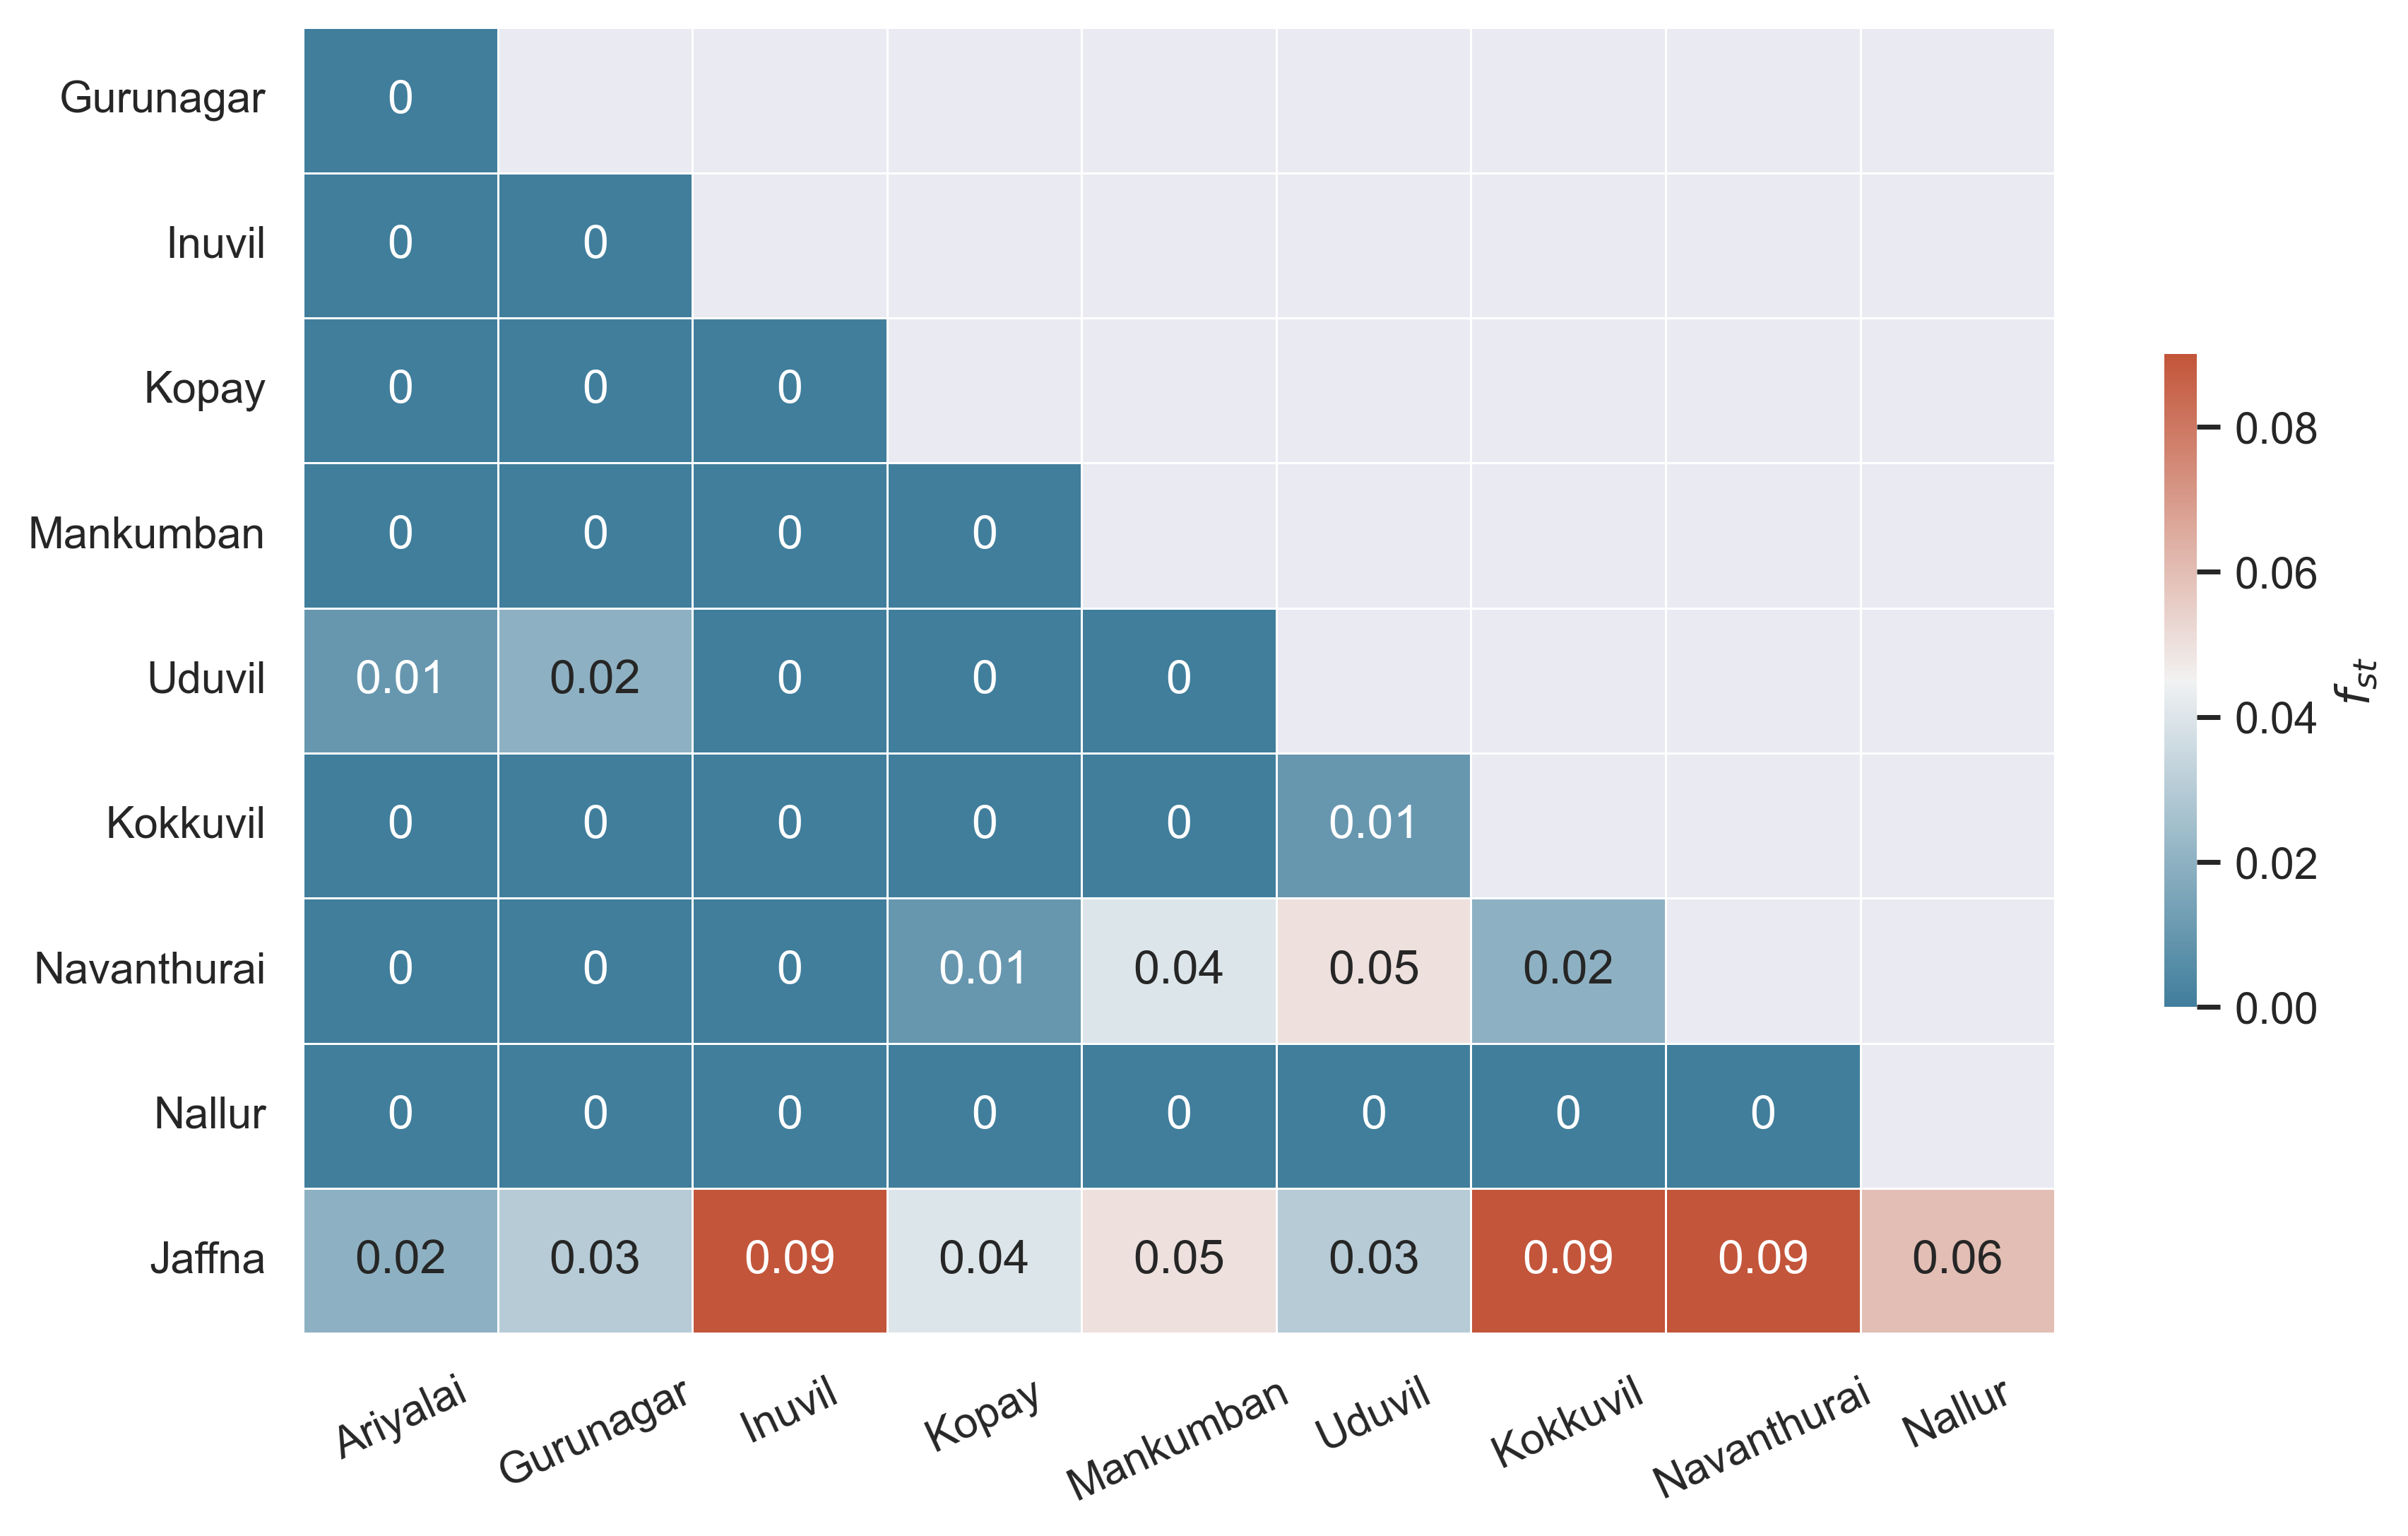

In [20]:
sns.set(rc = {'figure.figsize':(10,6)})
pairs = pairfst.pivot("Population 2", "Population 1", "fst mean")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(pairs, annot=True, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5, 'label': '$f_{st}$'})
plt.xticks(rotation=25)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

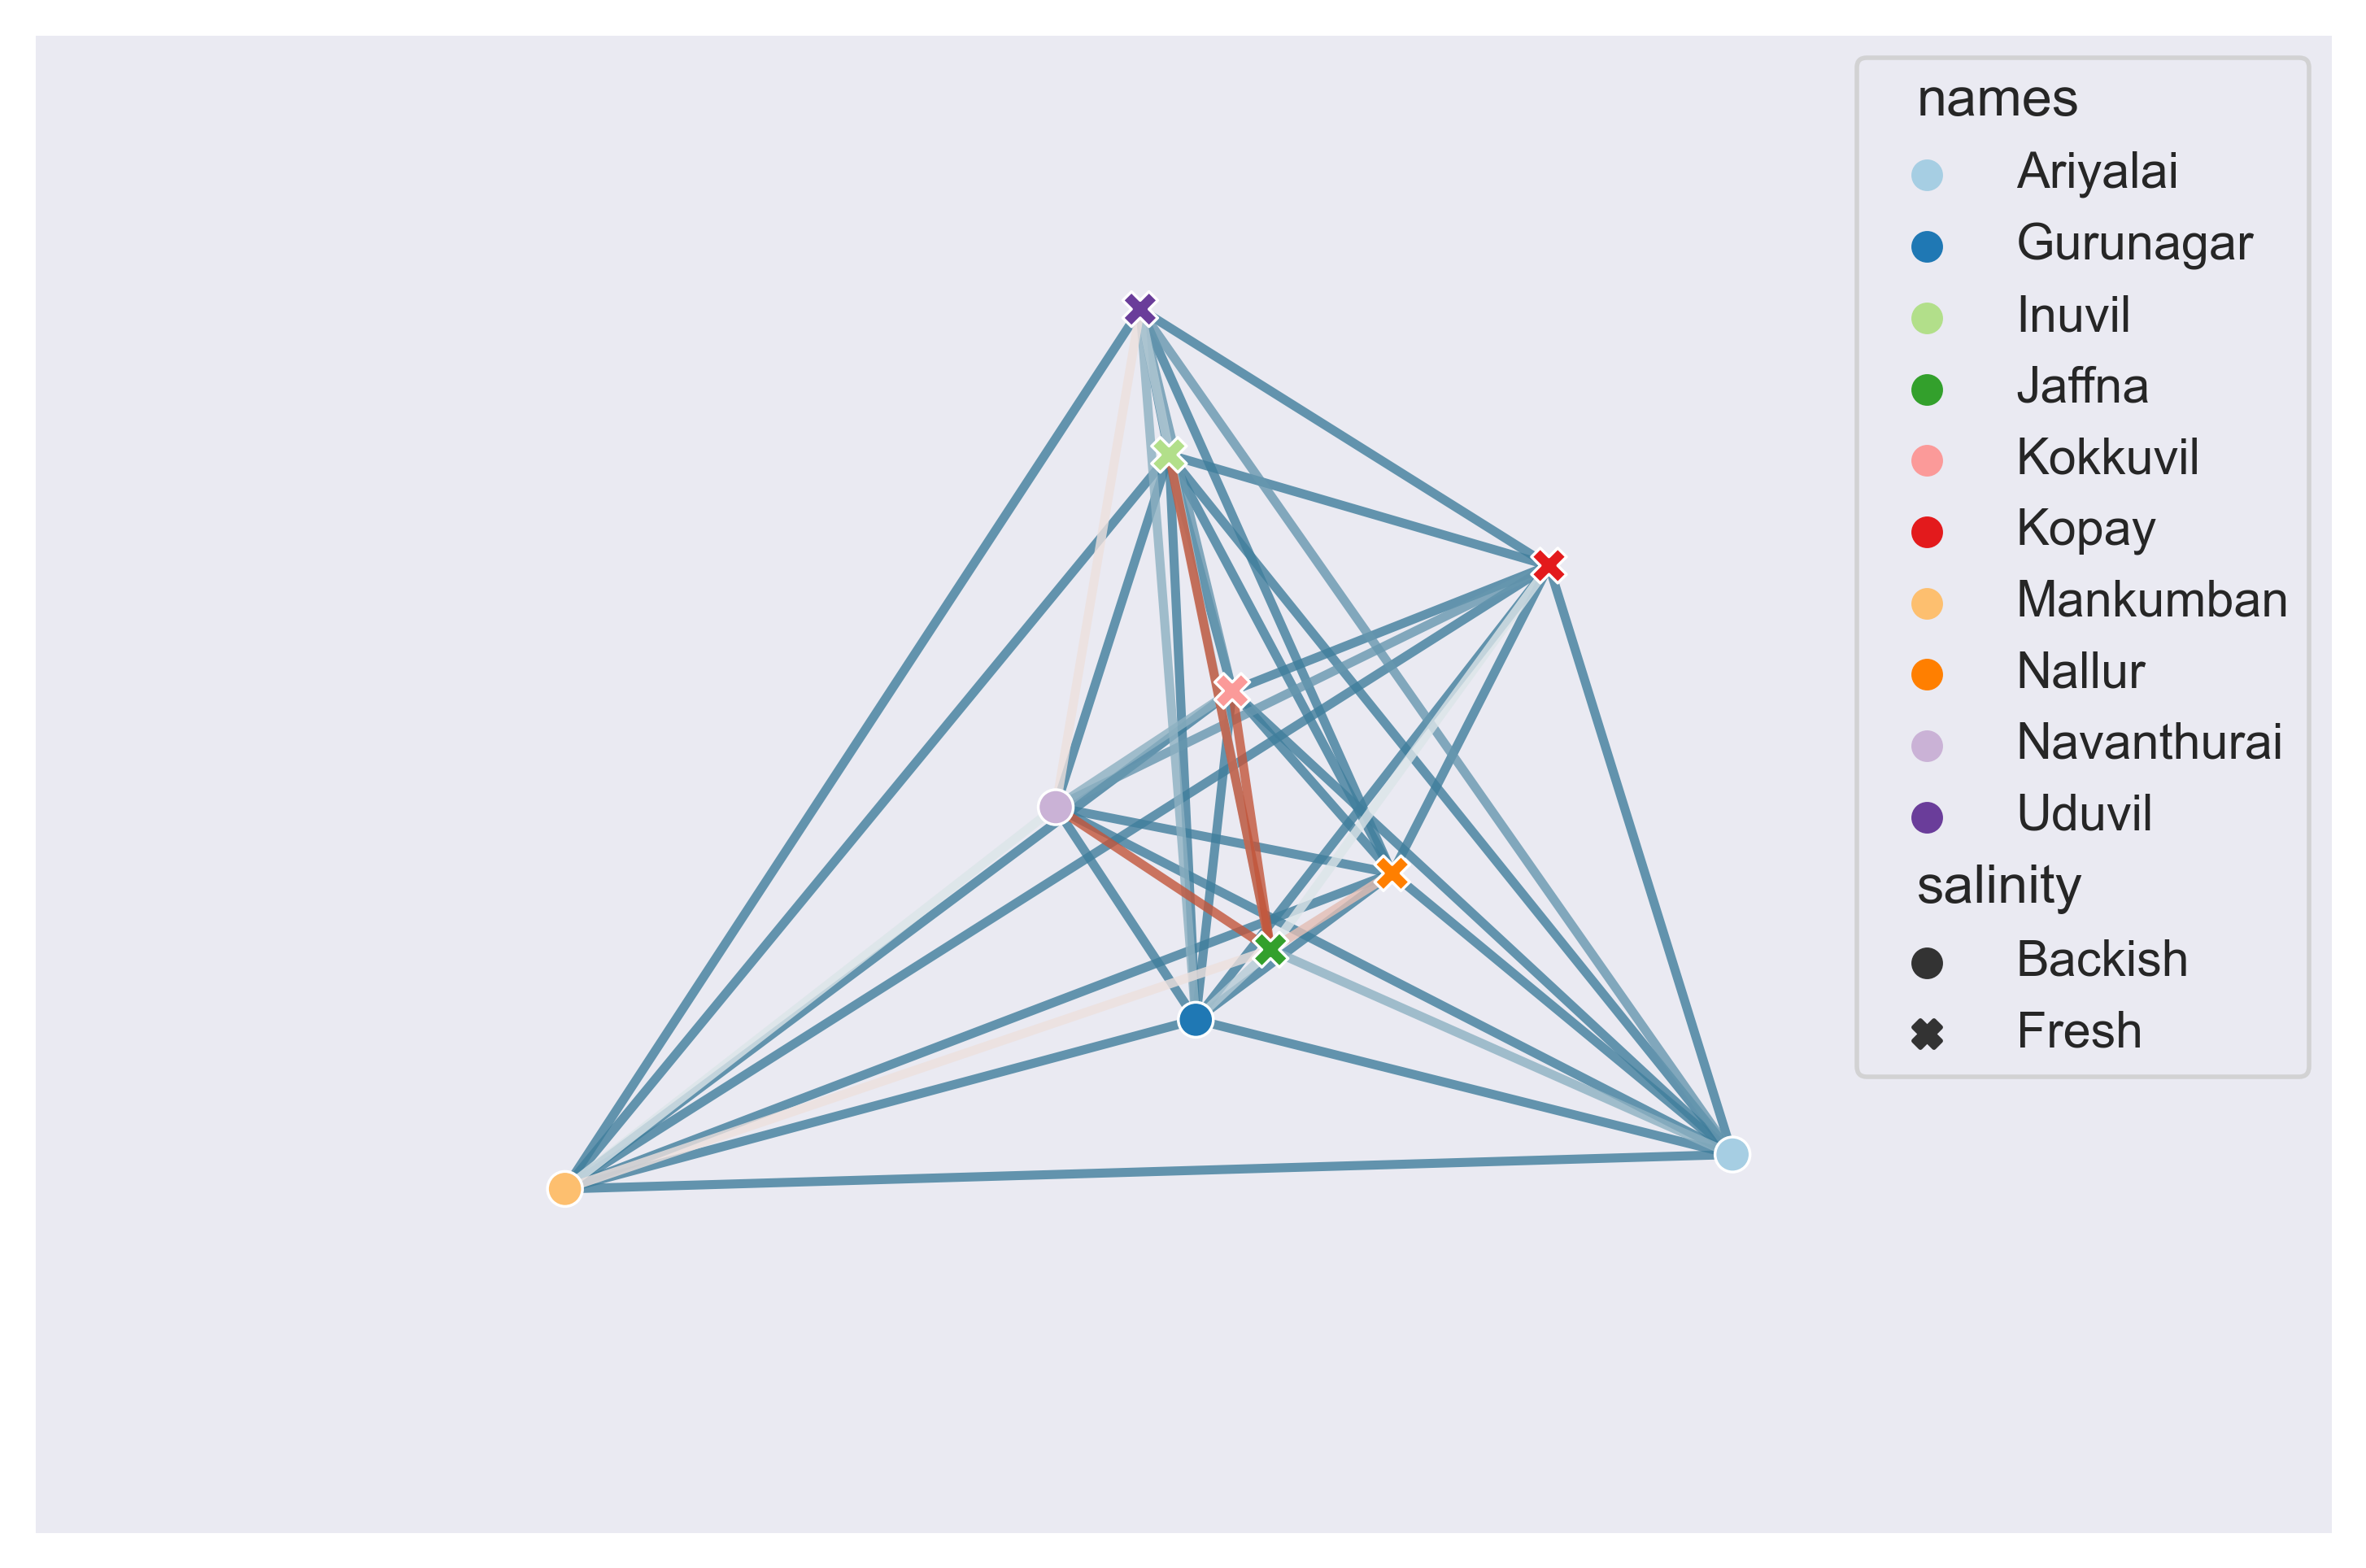

In [21]:
lons = [80.0786359, 80.01695029999999, 80.0008524,80.02554649999999,  
         79.94445259999999, 80.0395205, 80.021143,80.01056179999999, 80.05754,80.01387659467527]
lats = [9.6382902, 9.6535589, 9.677645799999999, 9.6614981, 9.6343901, 9.670154700000001, 9.690824, 9.7340655,9.705016,  9.717561538315094]
locations = ["Ariyalai", "Gurunagar", "Navanthurai", "Jaffna", "Mankumban", "Nallur", "Kokkuvil", "Uduvil", "Kopay", "Inuvil"]
is_salinty = ['Backish', 'Backish', 'Backish', 'Fresh', 'Backish', 'Fresh', 'Fresh', 'Fresh', 'Fresh', 'Fresh']
locs = pd.DataFrame({"logitude": lons, "latitudes": lats, "names": locations, "salinity": is_salinty})
locs = locs.sort_values(by="names")
location_dict = {locations[i]: [lons[i], lats[i]] for i in range(len(locations))}

latN = 9.7654
latS = 9.59512
lonW = 79.88326
lonE = 80.14779
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2

import cartopy.io.img_tiles as cimgt

request = cimgt.GoogleTiles(style="satellite")
fig = plt.figure()
ax = plt.axes(projection=request.crs)
ax.set_extent([lonW, lonE, latS, latN])
# add google maps
request = cimgt.GoogleTiles(style="satellite")
# ax.add_image(request, 12)

# add sample location
cmap = sns.diverging_palette(230, 20, as_cmap=True)
max_fst = max(pairfst["fst mean"])
min_fst = min(pairfst["fst mean"])
for i, row in pairfst.sort_values(by="fst mean").iterrows():
    if row["Population 1"] != row["Population 2"]:
        cor1 = location_dict[row["Population 2"]]
        cor2 = location_dict[row["Population 1"]]
        frac_total = (row["fst mean"] - min_fst) / (max_fst+abs(min_fst))
        ax.plot([cor1[0], cor2[0]], [cor1[1], cor2[1]], transform=ccrs.PlateCarree(), color=cmap(frac_total), alpha=0.8, linewidth=2)

sns.set_palette("Paired")
sns.scatterplot(data=locs, x="logitude", y="latitudes", transform=ccrs.PlateCarree(), ax=ax, zorder=99, style="salinity", hue="names", s=60)

# norm = mpl.colors.Normalize(vmin=min_fst, vmax=max_fst)
# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax, orientation='horizontal', label='Some Units')
plt.show()

/tmp/ipykernel_10240/69773122.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),


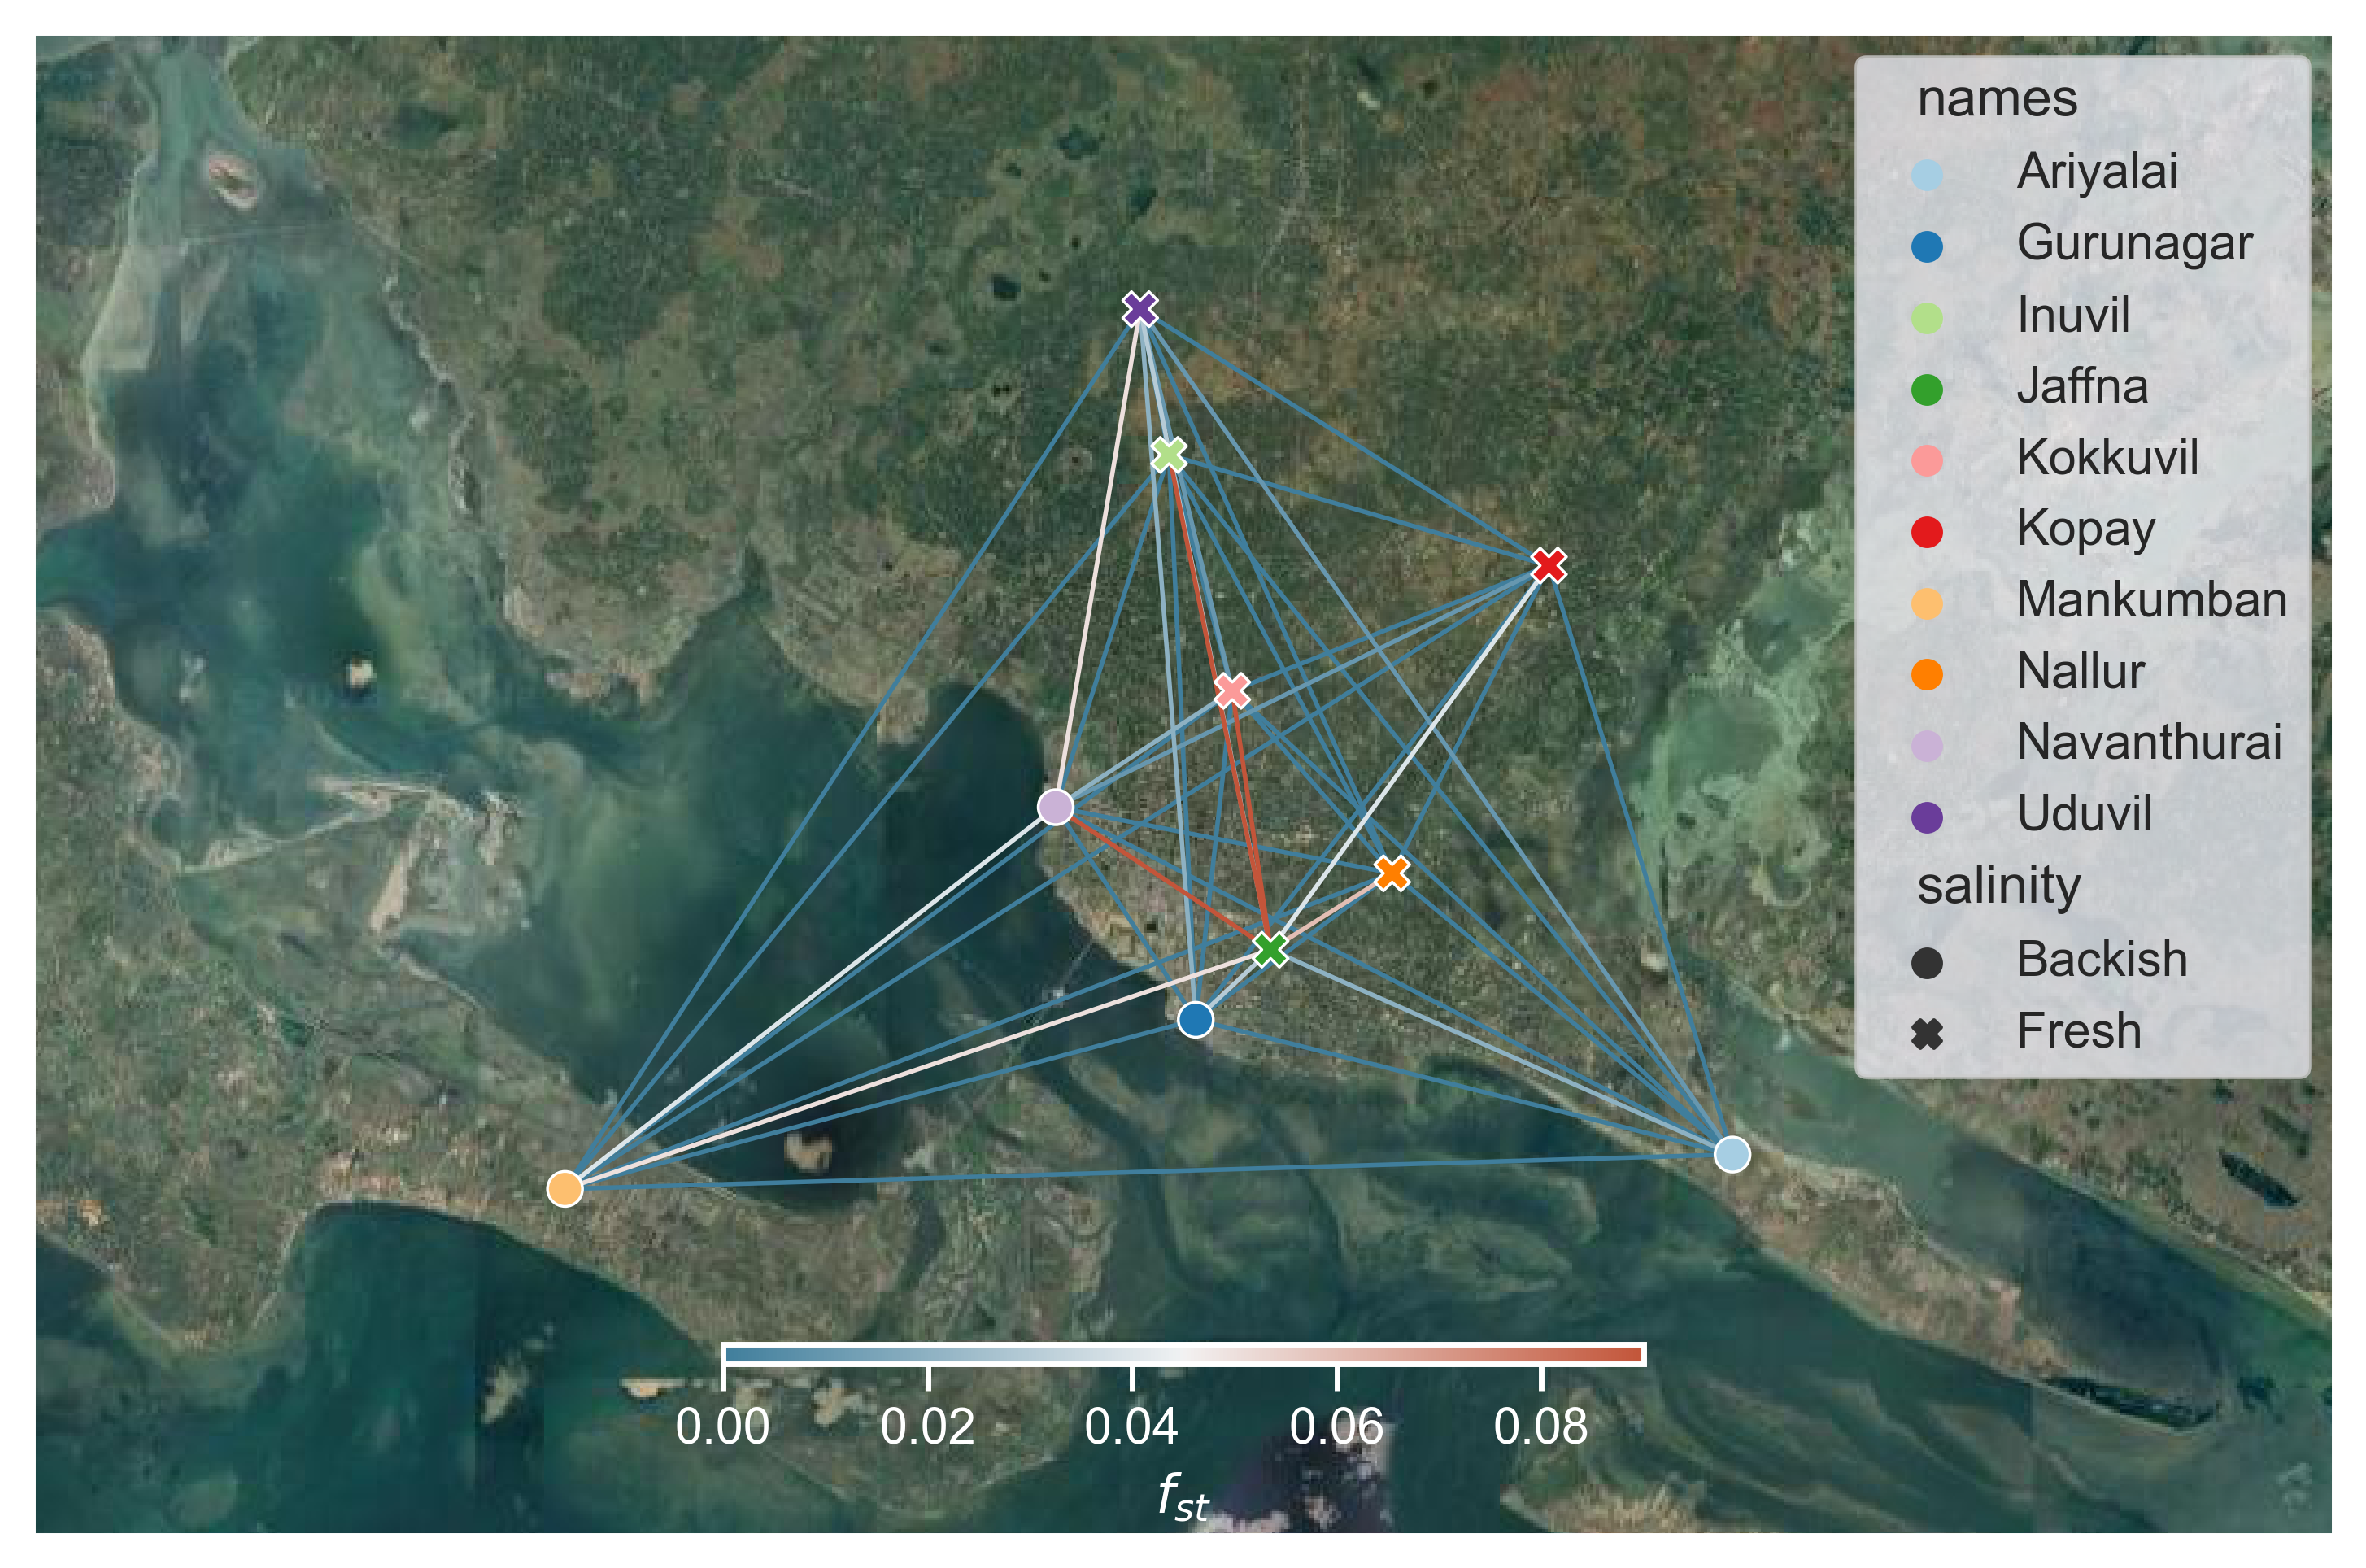

In [39]:
lons = [80.0786359, 80.01695029999999, 80.0008524,80.02554649999999,  
         79.94445259999999, 80.0395205, 80.021143,80.01056179999999, 80.05754,80.01387659467527]
lats = [9.6382902, 9.6535589, 9.677645799999999, 9.6614981, 9.6343901, 9.670154700000001, 9.690824, 9.7340655,9.705016,  9.717561538315094]
locations = ["Ariyalai", "Gurunagar", "Navanthurai", "Jaffna", "Mankumban", "Nallur", "Kokkuvil", "Uduvil", "Kopay", "Inuvil"]
is_salinty = ['Backish', 'Backish', 'Backish', 'Fresh', 'Backish', 'Fresh', 'Fresh', 'Fresh', 'Fresh', 'Fresh']
locs = pd.DataFrame({"logitude": lons, "latitudes": lats, "names": locations, "salinity": is_salinty})
locs = locs.sort_values(by="names")
location_dict = {locations[i]: [lons[i], lats[i]] for i in range(len(locations))}

latN = 9.7654
latS = 9.59512
lonW = 79.88326
lonE = 80.14779
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2

import cartopy.io.img_tiles as cimgt

fig = plt.figure()
ax = plt.axes(projection=request.crs)
ax.set_extent([lonW, lonE, latS, latN])
# add google maps
request = cimgt.GoogleTiles(style="satellite")
ax.add_image(request, 12)

# add sample location
cmap = sns.diverging_palette(230, 20, as_cmap=True)
max_fst = max(pairfst["fst mean"])
min_fst = min(pairfst["fst mean"])
for i, row in pairfst.sort_values(by="fst mean").iterrows():
    if row["Population 1"] != row["Population 2"]:
        cor1 = location_dict[row["Population 2"]]
        cor2 = location_dict[row["Population 1"]]
        frac_total = (row["fst mean"] - min_fst) / (max_fst+abs(min_fst))
        ax.plot([cor1[0], cor2[0]], [cor1[1], cor2[1]], transform=ccrs.PlateCarree(), color=cmap(frac_total), linewidth=1)

sns.set_palette("Paired")
sns.scatterplot(data=locs, x="logitude", y="latitudes", transform=ccrs.PlateCarree(), ax=ax, zorder=99, style="salinity", hue="names", s=60)

l, b, w, h = ax.get_position().bounds
cax = fig.add_axes([l + (w * 0.6)/2, # adjustment so it is centered 
                    b + (b* 0.8), #increasing makes go higher 
                    w * 0.4, # width
                    0.01])
norm = mpl.colors.Normalize(vmin=min_fst, vmax=max_fst)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal').set_label(color="white", label='$f_{st}$')
# cb.set_label(color="white", label='$f_{st}$')

params = {
          "xtick.color" : "white",
          "ytick.color" : "white"}
plt.rcParams.update(params)

# norm = mpl.colors.Normalize(vmin=min_fst, vmax=max_fst)
# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax, orientation='horizontal', label='Some Units')
plt.show()


In [28]:
!rm -r ../../../UniprotKB_RT/deepCluster10

/tmp/ipykernel_18475/2987367354.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),


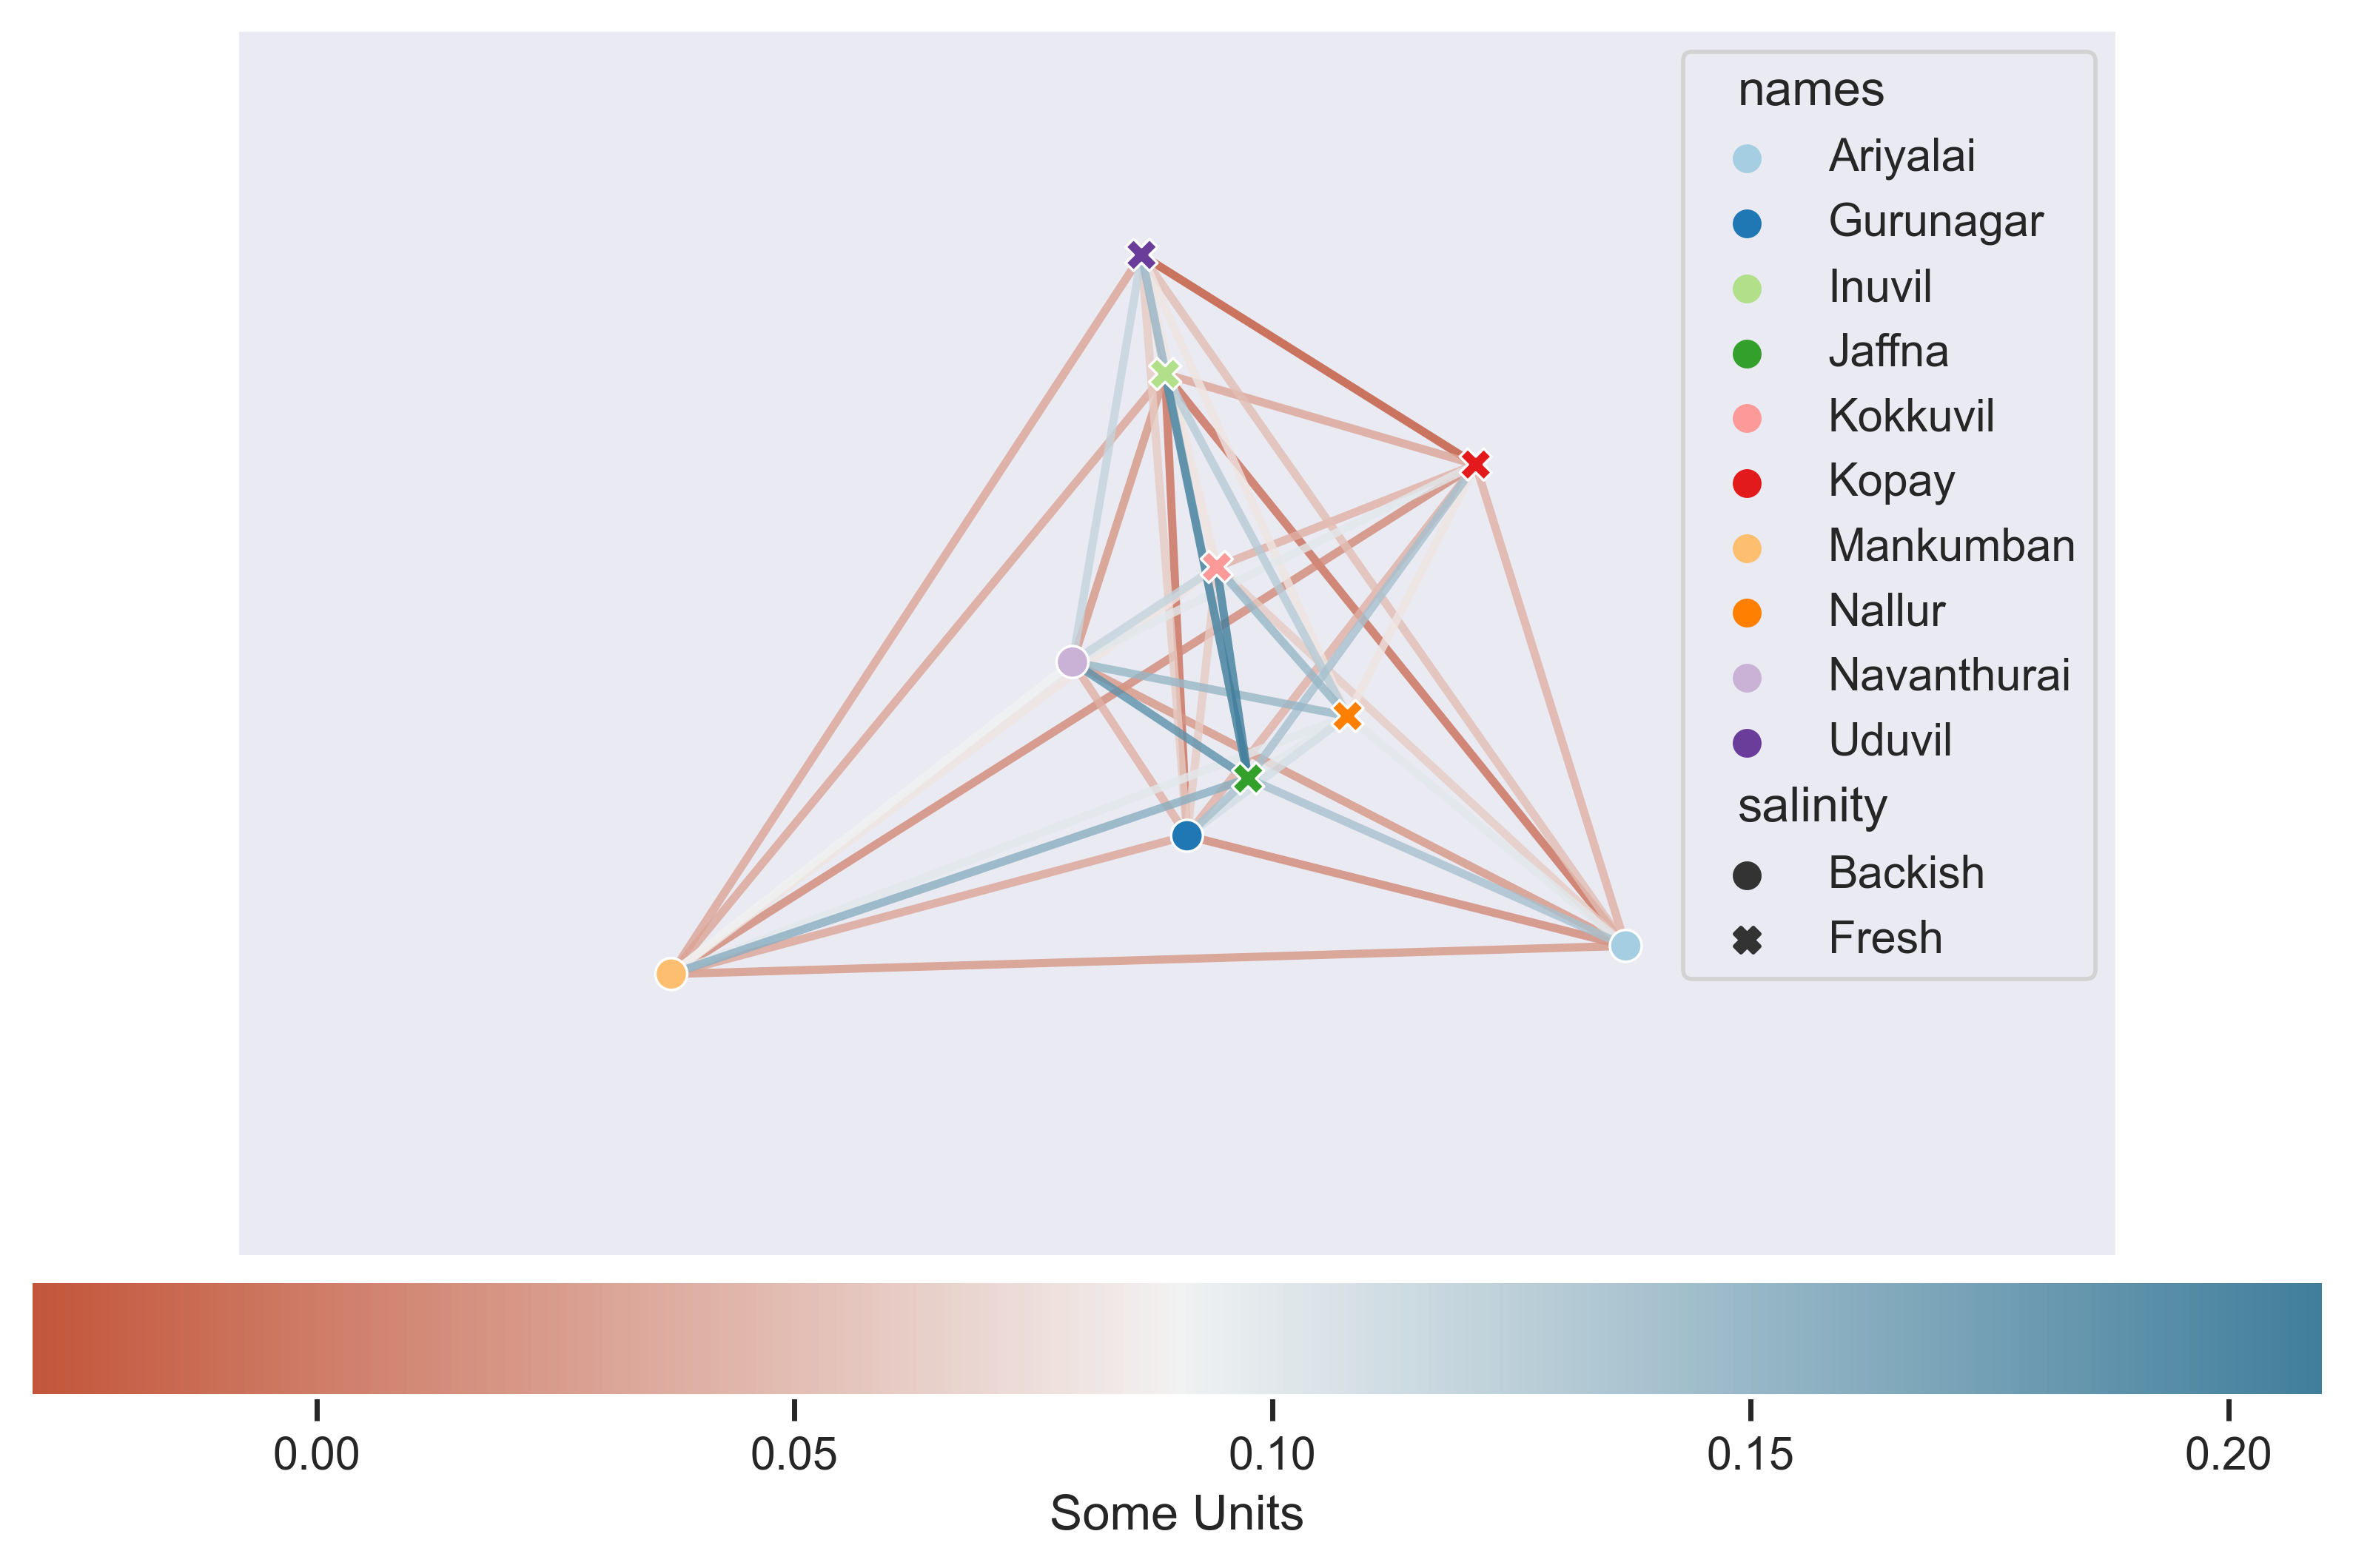

In [199]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax = fig.add_subplot(10, 1, (1,9), projection=request.crs)
ax.set_extent([lonW, lonE, latS, latN])
# add google maps
request = cimgt.GoogleTiles(style="satellite")
# ax.add_image(request, 12)

# add sample location
cmap = sns.diverging_palette(20, 230, as_cmap=True)
max_fst = max(pairfst["fst mean"])
min_fst = min(pairfst["fst mean"])
for i, row in pairfst.sort_values(by="fst mean").iterrows():
    if row["Population 1"] != row["Population 2"]:
        cor1 = location_dict[row["Population 2"]]
        cor2 = location_dict[row["Population 1"]]
        frac_total = (row["fst mean"] - min_fst) / (max_fst+abs(min_fst))
        ax.plot([cor1[0], cor2[0]], [cor1[1], cor2[1]], transform=ccrs.PlateCarree(), color=cmap(frac_total), alpha=0.8, linewidth=2)

sns.set_palette("Paired")
im = sns.scatterplot(data=locs, x="logitude", y="latitudes", transform=ccrs.PlateCarree(), ax=ax, zorder=99, style="salinity", hue="names", s=60)

ax = fig.add_subplot(10, 1, 10)
norm = mpl.colors.Normalize(vmin=min_fst, vmax=max_fst)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Some Units', fraction=0.046)
plt.show()

In [108]:
abs(-1)

1

In [145]:
!wget https://osmdata.openstreetmap.de/download/land-polygons-complete-4326.zip

--2023-01-09 12:10:17--  https://osmdata.openstreetmap.de/download/land-polygons-complete-4326.zip
Resolving osmdata.openstreetmap.de (osmdata.openstreetmap.de)... 116.203.99.53
Connecting to osmdata.openstreetmap.de (osmdata.openstreetmap.de)|116.203.99.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812291415 (775M) [application/zip]
Saving to: ‘land-polygons-complete-4326.zip’

100%[======================================>] 812,291,415  958KB/s   in 13m 53s

2023-01-09 12:24:11 (952 KB/s) - ‘land-polygons-complete-4326.zip’ saved [812291415/812291415]



In [148]:
!unzip maps/land-polygons-complete-4326.zip

Archive:  maps/land-polygons-complete-4326.zip
 extracting: land-polygons-complete-4326/land_polygons.cpg  
  inflating: land-polygons-complete-4326/land_polygons.dbf  
  inflating: land-polygons-complete-4326/land_polygons.prj  
  inflating: land-polygons-complete-4326/land_polygons.shp  
  inflating: land-polygons-complete-4326/land_polygons.shx  
  inflating: land-polygons-complete-4326/README.txt  


# Association analysis

In [10]:
df = pd.read_csv("phenotypes.txt", sep='\t')
df = df[df["IID"].isin(metadata_unrelated["IID"])]
df.to_csv("phenotypes_unrelated.txt", index=None, sep="\t")

In [18]:
!../../plink/plink --bfile SriLanka_no_sib --logistic --adjust --pheno ../analysis/sri_lanka_phenotypes.txt --pheno-name isBW --out SriLanka_no_sib_logistic --allow-no-sex --allow-extra-chr --chr 3001 3002 3003

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SriLanka_no_sib_logistic.log.
Options in effect:
  --adjust
  --allow-extra-chr
  --allow-no-sex
  --bfile SriLanka_no_sib
  --chr 3001 3002 3003
  --logistic
  --out SriLanka_no_sib_logistic
  --pheno ../analysis/sri_lanka_phenotypes.txt
  --pheno-name isBW

128238 MB RAM detected; reserving 64119 MB for main workspace.
10545 out of 11007 variants loaded from .bim file.
30 people (0 males, 0 females, 30 ambiguous) loaded from .fam.
Ambiguous sex IDs written to SriLanka_no_sib_logistic.nosex .
30 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 30 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747

In [3]:
df = pd.read_csv("SriLanka_no_sib_logistic.assoc.logistic", sep="\s+")
df_adjusted = pd.read_csv("SriLanka_no_sib_logistic.assoc.logistic.adjusted", sep="\s+")
df_adjusted = df_adjusted[['SNP', 'BONF']]
df_all = pd.merge(df, df_adjusted, how="left", on="SNP")
df_all.to_csv("SriLanka_no_sib_logistic_with_BONF.assoc.logistic", sep=",", index=False)

In [9]:
assoc = pd.read_csv("SriLanka_no_sib_logistic_with_BONF.assoc.logistic")
assoc["-logp"] = - np.log10(assoc["BONF"])
assoc

CHR          SNP         BP A1 TEST  NMISS        OR      STAT  \
0      3003  AX-93233747      53666  C  ADD     30  1.375000  0.247700   
1      3003  AX-93233753      69429  G  ADD     30  0.591000 -1.109000   
2      3003  AX-93233757     108122  C  ADD     30       NaN       NaN   
3      3003  AX-93233758     118514  A  ADD     30  0.928600 -0.122000   
4      3003  AX-93233760     134475  G  ADD     30  1.124000  0.215800   
...     ...          ...        ... ..  ...    ...       ...       ...   
10540  3001  AX-93249158  310505644  A  ADD     30  0.000237 -0.008343   
10541  3001  AX-93249159  310509391  A  ADD     30  4.245000  1.863000   
10542  3001  AX-93261503  310660610  A  ADD     30  0.409900 -1.485000   
10543  3001  AX-93261500  310756621  T  ADD     30  0.000237 -0.008343   
10544  3001  AX-93263208  310811627  T  ADD     30  8.689000  2.632000   

             P  BONF  -logp  
0      0.80440   1.0   -0.0  
1      0.26750   1.0   -0.0  
2          NaN   NaN    NaN  
3      0.90290   1.0   -0.0  
4      0.82920   1.0   -0.0  
...        ...   ...    ...  
10540  0.99330   1.0   -0.0  
10541  0.06240   1.0   -0.0  
10542  0.13740   1.0   -0.0  
10543  0.99330   1.0   -0.0  
10544  0.00848   1.0   -0.0  

[10545 rows x 11 columns]

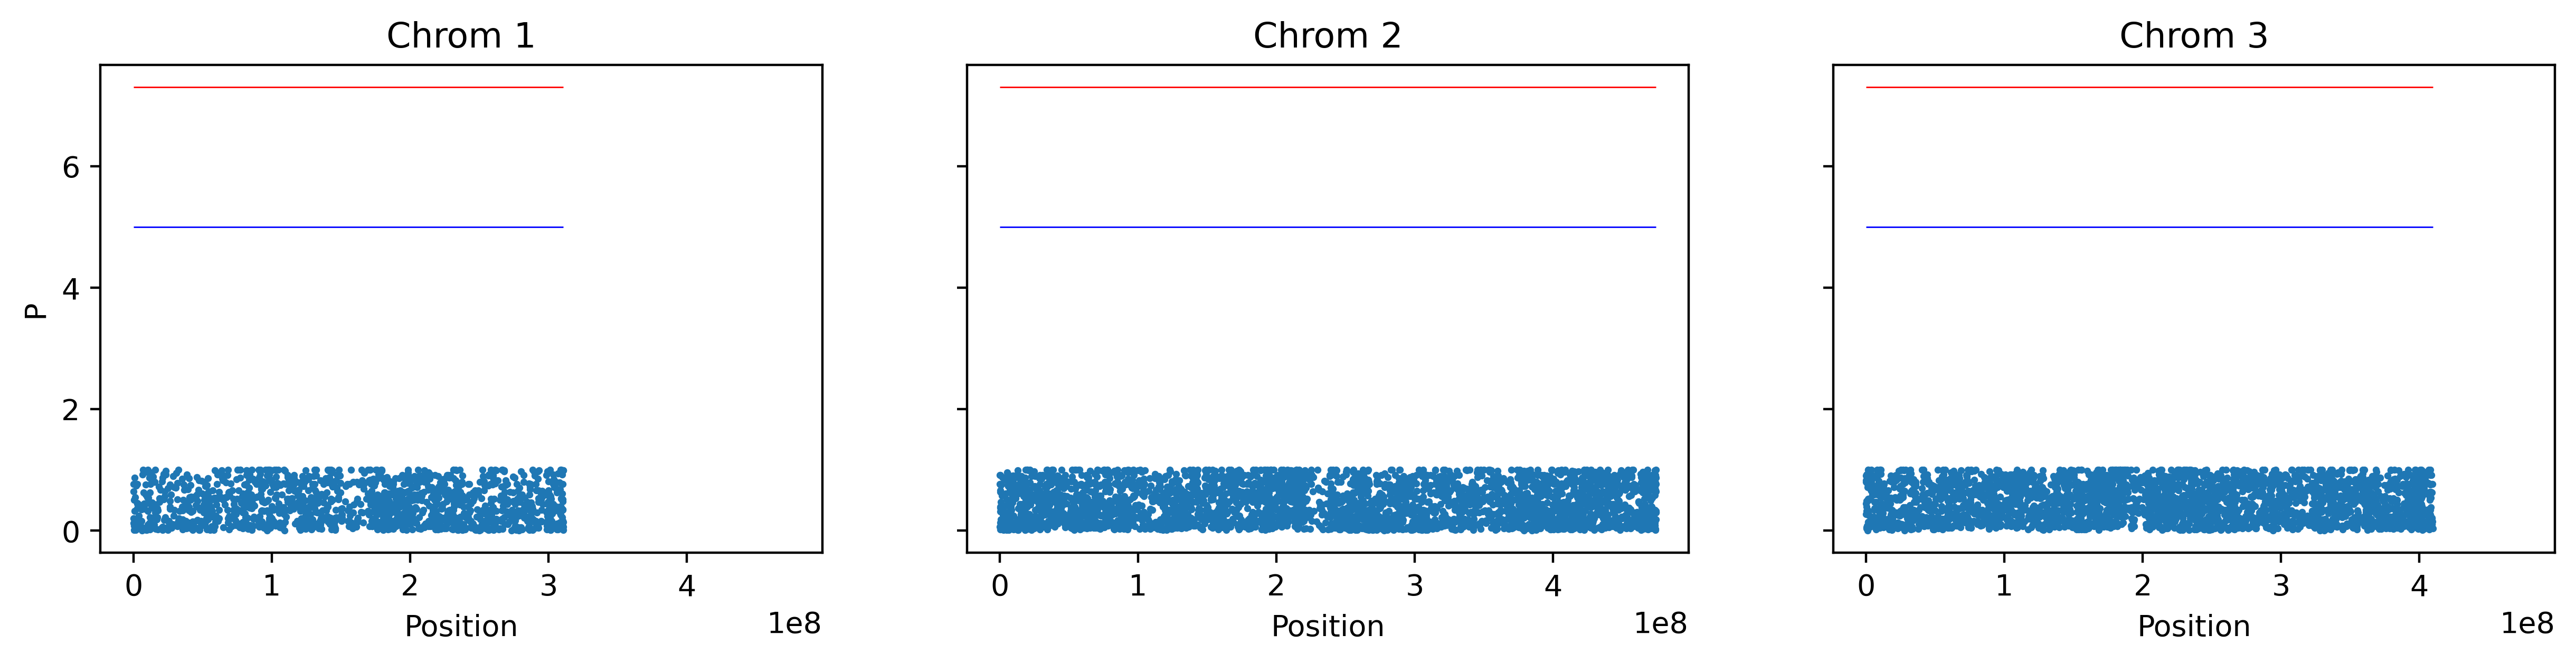

In [10]:
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True,  figsize=(5*3, 3))
ax[0].set_ylabel("P")

for i, chrom in enumerate([3001, 3002, 3003]):
    one_chrom_snps = assoc[assoc["CHR"] == chrom]
    ax[i].set_title(f"Chrom {i + 1}")
    ax[i].scatter(one_chrom_snps["BP"], one_chrom_snps["P"], s=2)
    ax[i].set_xlabel("Position")
    ax[i].hlines(y=-np.log10(5e-8), xmin=0.0, xmax=max(one_chrom_snps["BP"]), color='r', linewidth=0.5)
    ax[i].hlines(y=-np.log10(1e-5), xmin=0.0, xmax=max(one_chrom_snps["BP"]), color='b', linewidth=0.5)
fig.show()

In [14]:
!cp ../analysis/GWAS/mart_export.txt . 

In [9]:
metadata = pd.read_csv("sri_lanka_metadata.txt", sep="\t")
metadata = metadata.rename(columns={"Sample": "IID"})
metadata["salinity"] = metadata["Phenotype"].str.extract("(\d*)").astype(int)

PC = pd.read_csv("plink.eigenvec", sep="\t")
PC_data = pd.merge(PC, metadata, on="IID", how="left")
FW = PC_data[PC_data["salinity"] > 0]
FW = FW.melt(id_vars=["City"], value_vars="salinity")
FW = FW.rename(columns={'value': 'salinity'})
FW

City  variable  salinity
0     Gurunagar  salinity         8
1     Gurunagar  salinity         8
2     Gurunagar  salinity         8
3     Gurunagar  salinity         8
4     Gurunagar  salinity         8
5     Gurunagar  salinity         8
6     Gurunagar  salinity         8
7     Gurunagar  salinity         8
8     Gurunagar  salinity         8
9   Navanthurai  salinity         8
10  Navanthurai  salinity         8
11  Navanthurai  salinity         8
12  Navanthurai  salinity         8
13  Navanthurai  salinity         8
14  Navanthurai  salinity         8
15  Navanthurai  salinity         8
16  Navanthurai  salinity         8
17  Navanthurai  salinity         8
18     Ariyalai  salinity         8
19     Ariyalai  salinity         8
20     Ariyalai  salinity         8
21     Ariyalai  salinity         8
22     Ariyalai  salinity         8
23     Ariyalai  salinity         8
24     Ariyalai  salinity         8
25     Ariyalai  salinity         8
26     Ariyalai  salinity         8
27    Gurunagar  salinity         6
28    Gurunagar  salinity         6
29     Ariyalai  salinity         4
30     Ariyalai  salinity         4
31     Ariyalai  salinity         4
32     Ariyalai  salinity         4
33    Mankumban  salinity        12
34    Mankumban  salinity        12
35    Mankumban  salinity        12
36    Mankumban  salinity        12

In [3]:
!cp ../analysis/phase2/BW_nt_diversity_100.windowed.pi .
!cp ../analysis/phase2/FW_nt_diversity_100.windowed.pi .

In [16]:
diff_genes = pd.read_csv("mart_export.txt")
diff_genes = diff_genes.drop_duplicates(subset="Gene stable ID")
len(diff_genes)
diff_genes

Gene stable ID Gene stable ID version Transcript stable ID  \
0       AAEL000637           AAEL000637.2        AAEL000637-RB   
1       AAEL000834           AAEL000834.3        AAEL000834-RC   
3       AAEL001063           AAEL001063.3        AAEL001063-RA   
4       AAEL001237           AAEL001237.3        AAEL001237-RB   
5       AAEL001553           AAEL001553.2        AAEL001553-RA   
..             ...                    ...                  ...   
234     AAEL027789           AAEL027789.1        AAEL027789-RA   
235     AAEL027804           AAEL027804.1        AAEL027804-RA   
236     AAEL027975           AAEL027975.1        AAEL027975-RA   
237     AAEL028247           AAEL028247.1        AAEL028247-RA   
238     AAEL029015           AAEL029015.1        AAEL029015-RB   

    Transcript stable ID version Chromosome/scaffold name  Gene start (bp)  \
0                AAEL000637-RB.1                        3        394631141   
1                AAEL000834-RC.1                        3        363894690   
3                AAEL001063-RA.1                        1        300928780   
4                AAEL001237-RB.1                        2        373200708   
5                AAEL001553-RA.1                        2         22346507   
..                           ...                      ...              ...   
234              AAEL027789-RA.1                        2        105158326   
235              AAEL027804-RA.1                        2        288546629   
236              AAEL027975-RA.1                        2        178905912   
237              AAEL028247-RA.1                        1        155551431   
238              AAEL029015-RB.1                        1        223319498   

    Gene name  Gene end (bp)  Transcript count Source of gene name  \
0         NaN      394635310                 1                 NaN   
1         NaN      363901819                 2                 NaN   
3         NaN      300930555                 1                 NaN   
4         NaN      373213348                 1                 NaN   
5         NaN       22396010                 1                 NaN   
..        ...            ...               ...                 ...   
234       NaN      105158918                 1                 NaN   
235       NaN      288548453                 1                 NaN   
236       NaN      178922114                 1                 NaN   
237       NaN      155563324                 1                 NaN   
238       NaN      223352947                 3                 NaN   

     Transcript length (including UTRs and CDS)               Gene description  
0                                          3994                            NaN  
1                                          2146  dimethylaniline monooxygenase  
3                                          1713                            NaN  
4                                          1896                            NaN  
5                                          2340                            NaN  
..                                          ...                            ...  
234                                         493                            NaN  
235                                        1752                            NaN  
236                                        3628                            NaN  
237                                        1724                            NaN  
238                                         652                            NaN  

[154 rows x 12 columns]

# Nucleotide diversity

Run with
```
!module load VCFtools && vcftools --vcf ../SriLanka_only_relate.vcf --window-pi 100000 --out BW_nt_diversity_100 --keep ../BW_samples_all.txt
```

(0.0, 5994.0)

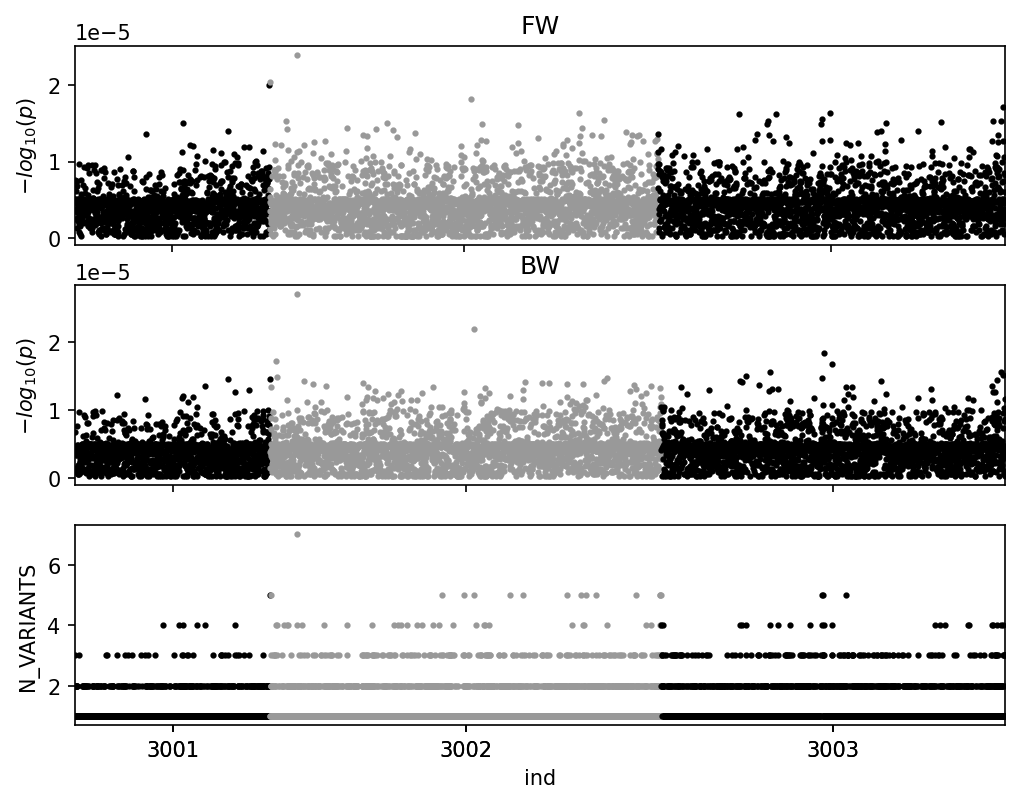

In [6]:
fst1 = pd.read_csv("FW_nt_diversity_100.windowed.pi", sep="\t")
fst1 = fst1[fst1["CHROM"].isin([3001, 3002, 3003])]
fst1 = fst1.sort_values(['CHROM', 'BIN_START'])
fst1['ind'] = range(len(fst1))
assoc_grouped = fst1.groupby(('CHROM'))
fig = plt.figure(dpi=150, figsize=(8, 6))

ax = fig.add_subplot(311)
colors = ['#000000','#999999','#000000']
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(assoc_grouped):
    group.plot(kind='scatter', x='ind', y='PI',color=colors[num % len(colors)], ax=ax, s=4)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
ax.set_xticks(x_labels_pos)
ax.set_xticklabels([])
ax.set_title("FW")
ax.set_xlabel('')
ax.set_xlim([0, len(fst1)])
# ax.set_ylim([0, 9])
ax.set_ylabel("$-log_{10}(p)$")
# ax.set_xlabel('Chromosome')
# ax.hlines(y=-np.log10(5e-8), xmin=0.0, xmax=len(fst), color='r', linewidth=0.5)
# ax.hlines(y=-np.log10(1e-5), xmin=0.0, xmax=len(fst), color='b', linewidth=0.5)


fst = pd.read_csv("BW_nt_diversity_100.windowed.pi", sep="\t")
fst = fst[fst["CHROM"].isin([3001, 3002, 3003])]
fst = fst.sort_values(['CHROM', 'BIN_START'])
fst['ind'] = range(len(fst))
assoc_grouped = fst.groupby(('CHROM'))
ax = fig.add_subplot(312)
colors = ['#000000','#999999','#000000']
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(assoc_grouped):
    group.plot(kind='scatter', x='ind', y='PI',color=colors[num % len(colors)], ax=ax, s=4)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
ax.set_xticks(x_labels_pos)
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_xlim([0, len(fst)])
ax.set_title("BW")
ax.set_ylabel("$-log_{10}(p)$")
# ax.set_xlabel('Chromosome')



ax = fig.add_subplot(313)
for num, (name, group) in enumerate(assoc_grouped):
    group.plot(kind='scatter', x='ind', y='N_VARIANTS',color=colors[num % len(colors)], ax=ax, s=4)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(fst)])

Text(0.5, 0, 'n variants in 100kb window')

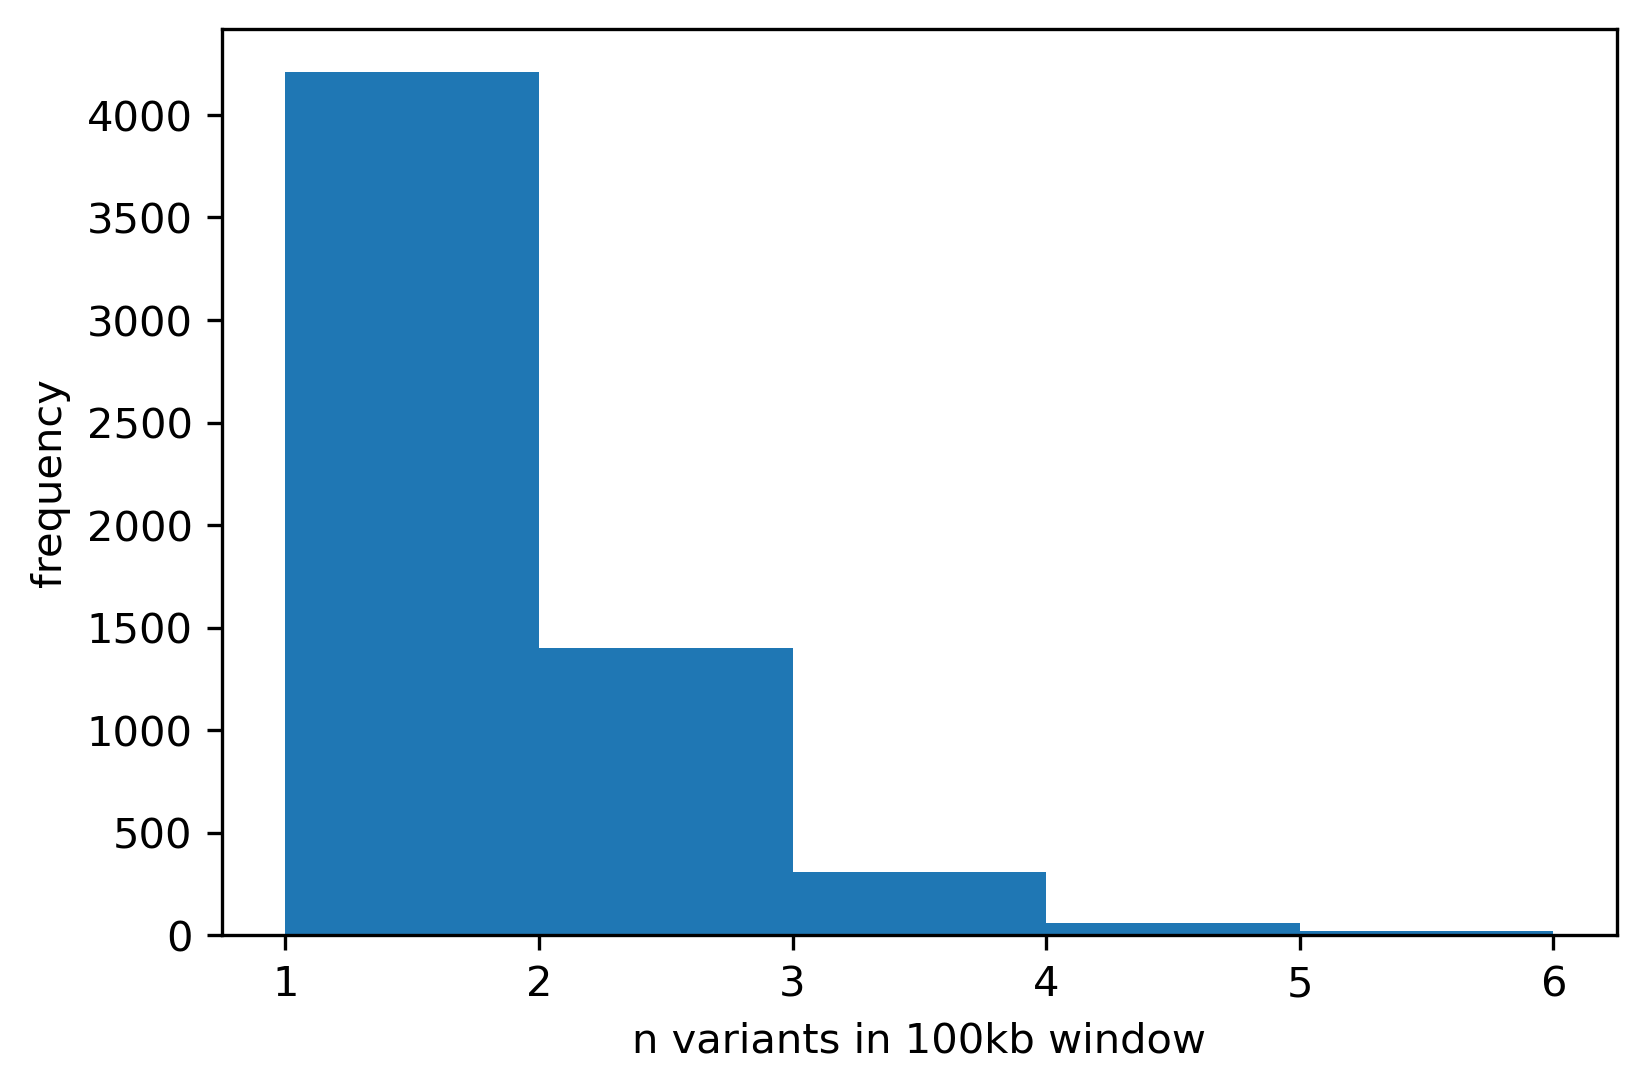

In [13]:
fst1 = pd.read_csv("FW_nt_diversity_100.windowed.pi", sep="\t")
fst1 = fst1[fst1["CHROM"].isin([3001, 3002, 3003])]
fst1 = fst1.sort_values(['CHROM', 'BIN_START'])
fst1['ind'] = range(len(fst1))

plt.hist(fst["N_VARIANTS"], bins=[1, 2, 3, 4, 5, 6])
plt.ylabel("frequency")
plt.xlabel("n variants in 100kb window")

# Fst